In [1]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import pandas as pd
import array
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.optimize import root
import seaborn as sns
from statistics import mode

# Geospatial data manipulation and raster operations
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline

from shapely.geometry import Point

# Electromagnetic induction data inversion package
from emagpy import Problem
from plots import *
from PM import *
%matplotlib inline

In [2]:
# -------------------------
################################################### Non-Calibrated data ##########################################

#FDEM_surveydata = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Code_EM_survey_case/survey_Lam72.csv'
#FDEM_transect = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Code_EM_survey_case/ERT_PH_set.csv'
#samples = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Code_EM_survey_case/samples_combined.csv'
#FDEM_surveydata = 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/EM case survey/Data/Proefhoeve/survey_042022/survey_Lam72.csv'
#FDEM_transect = 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/EM case survey/Code_EM_survey_case/ERT_PH_set.csv'
#samples = 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/EM case survey/Data/Proefhoeve/samples_combined.csv'

################################################### Calibrated data ##########################################

FDEM_surveydata = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Data/calibrated_EM_data/proefhoeve_421S_calibrated.csv'
FDEM_transect = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Data/calibrated_EM_data/transects/proefhoeve_421S_transect_calibrated.csv'
samples = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Data/calibrated_EM_data/samples_merge.csv'

################################################### Calibrated rECa data ##########################################

FDEM_surveydata = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Data/calibrated_EM_data/proefhoeve_421S_calibrated_rECa.csv'
FDEM_transect = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Data/calibrated_EM_data/transects/proefhoeve_421S_transect_calibrated_rECa.csv'
samples = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Data/calibrated_EM_data/samples_merge_rECa.csv'

# URL for grid masking file
blank_json = 'https://users.ugent.be/~pjdsmedt/ESS2023/blank.json'

# Create dataframes from datasets
'''
Import datasets as dataframes
-----------------------------
    - df = dataframe with the full FDEM dataset
    - dt = dataframe with the FDEM transect
    - ds = datasframe with the sample data (including analytical data)
    - blank = geojson (polygon) outlining survey extent
'''
df = pd.read_csv(FDEM_surveydata, sep=',', header=0)
dt = pd.read_csv(FDEM_transect, sep=',', header=0, encoding='cp1252')
ds = pd.read_csv(samples, sep=',', header=0, encoding='cp1252')
blank_in = gpd.read_file(blank_json)
blank = blank_in.to_crs('EPSG:31370')
ds.columns

Index(['Unnamed: 0.1', 'x', 'y', 'z', 't', 'HCP0.5', 'PRP0.6', 'HCP1.0',
       'PRP1.1', 'HCP2.0', 'PRP2.1', 'HCP0.5_inph', 'PRP0.6_inph',
       'HCP1.0_inph', 'PRP1.1_inph', 'HCP2.0_inph', 'PRP2.1_inph',
       'Unnamed: 0', 'x_clhs', 'y_clhs', 'z.1', 't.1', 'name', 'depth',
       'ph-eau', 'CEC', 'clay', 'silt', 'sand', 'TOC', 'humus', 'bd', 'vwc',
       'copeky', 'temp', 'rperm', 'iperm'],
      dtype='object')

## Preprocesingn

In [3]:
SheetsHendrickxEC(np.array([0.12, 0.25]), 20)

array([0.13352103, 0.27816881])

In [4]:
ds_c = ds.copy()
# Caclculate Bulk EC from HydraProbe data at 50Mhz
offset = 4
water_perm = 80
ds_c['bulk_ec_hp'] = logsdon(50e6, ds_c.rperm, ds_c.iperm)
z
# Caclculate Bulk EC from HydraProbe data at 0 Hz
def objective_func_ec_dc(bulk_ec_dc, frequency_ec, bulk_ec):
    return (LongmireSmithEC(bulk_ec_dc, frequency_ec) - bulk_ec)**2
bulk_ec_dc_hp = []

for i in range(len(ds_c.bulk_ec_hp.values)):
    res = minimize(objective_func_ec_dc, 0.05, args=(50e6, ds_c.bulk_ec_hp[i]), bounds=[(0, 1)])
    bulk_ec_dc_hp.append(np.nan if np.isnan(res.fun) else round(res.x[0], 5) )

ds_c['bulk_ec_dc_hp'] = bulk_ec_dc_hp
ds_c['bulk_ec_dc_hp_t'] = SheetsHendrickxEC( ds_c.bulk_ec_dc_hp, ds_c.temp)

# Caclculate Water EC from HydraProbe data at 50Mhz
ds_c['water_ec_hp'] = Hilhorst(ds_c.bulk_ec_hp, ds_c.rperm, water_perm, offset)
ds_c['water_ec_hp_t'] = WraithOr(ds_c.water_ec_hp, ds_c.temp)

ds_c['iperm_water_t'] = ds_c.water_ec_hp_t/(50e6*2*pi*epsilon_0)

# Caclculate Aparent Bulk EC from EMI at 0 Hz in S/m
EC_columns = ['HCP0.5', 'PRP0.6', 'HCP1.0', 'PRP1.1', 'HCP2.0', 'PRP2.1'] 
for col in EC_columns:
    EC_DC = []
    for i in range(len(ds_c[col].values)):
        res = minimize(objective_func_ec_dc, 0.05, args=(9e3, ds_c[col][i]), bounds=[(0, 1)])
        EC_DC.append(np.nan if np.isnan(res.fun) else round(res.x[0], 5) )

    ds_c[col+'_DC'] = EC_DC
    ds_c[col+'_DC_t'] = SheetsHendrickxEC(ds_c[col+'_DC'], ds_c.temp)

ds_c

,Unnamed: 0.1,x,y,z,t,HCP0.5,PRP0.6,HCP1.0,PRP1.1,HCP2.0,...,PRP0.6_DC,PRP0.6_DC_t,HCP1.0_DC,HCP1.0_DC_t,PRP1.1_DC,PRP1.1_DC_t,HCP2.0_DC,HCP2.0_DC_t,PRP2.1_DC,PRP2.1_DC_t
0,2647,107720.422,183327.165,26.201000,33302.50,0.002981,0.003123,0.000545,0.000793,0.000168,...,0.00274,0.002688,0.00043,0.000422,0.00064,0.000628,0.00010,0.000098,0.00009,0.000088
1,9662,107755.083,183330.802,26.855331,34836.56,0.001539,0.001415,0.000520,0.000502,0.000175,...,0.00119,0.001232,0.00040,0.000414,0.00039,0.000404,0.00010,0.000104,0.00009,0.000093
2,11087,107797.240,183278.473,27.948771,35121.56,0.006310,0.004190,0.001599,0.001538,0.000278,...,0.00371,0.003663,0.00136,0.001343,0.00130,0.001283,0.00016,0.000158,0.00035,0.000346
3,9694,107763.627,183318.268,27.208957,34842.93,0.000773,0.000874,0.000412,0.000257,0.000195,...,0.00071,0.000721,0.00031,0.000315,0.00015,0.000152,0.00011,0.000112,0.00008,0.000081
4,789,107722.801,183309.348,26.679000,32930.91,0.003629,0.003888,0.000546,0.000937,0.000169,...,0.00343,0.003485,0.00043,0.000437,0.00077,0.000782,0.00010,0.000102,0.00011,0.000112
5,7232,107742.964,183330.078,26.550000,34219.71,0.001886,0.001720,0.000488,0.000524,0.000176,...,0.00147,0.001481,0.00038,0.000383,0.00041,0.000413,0.00010,0.000101,0.00008,0.000081
6,11576,107805.582,183274.029,28.650000,35219.35,0.006515,0.003785,0.001760,0.001534,0.000293,...,0.00334,0.003257,0.00150,0.001463,0.00130,0.001268,0.00016,0.000156,0.00036,0.000351
7,7909,107758.569,183312.798,27.350000,34485.90,0.001158,0.001169,0.000463,0.000379,0.000194,...,0.00098,0.001046,0.00036,0.000384,0.00029,0.000309,0.00011,0.000117,0.00009,0.000096
8,11008,107776.575,183310.642,26.990019,35105.74,0.003380,0.002009,0.000996,0.000841,0.000228,...,0.00173,0.001769,0.00082,0.000839,0.00068,0.000695,0.00013,0.000133,0.00016,0.000164
9,2627,107726.042,183318.485,26.648100,33298.53,0.004526,0.004376,0.000733,0.001166,0.000175,...,0.00388,0.004018,0.00059,0.000611,0.00098,0.001015,0.00010,0.000104,0.00012,0.000124


In [5]:
R2_stochastic = pd.DataFrame(columns=['Target', 'Best EC feature', 'R2', 'Best EC feature 10cm', 'R2 10cm', 
                                      'Best EC feature 50cm', 'R2 50cm', 'Best EC feature combined', 'R2 combined', 'R2 combined2'],
                  index=range(0, 5))

RMSE_stochastic = pd.DataFrame(columns=['Target', 'Best EC feature', 'RMSE', 'Best EC feature 10cm', 'RMSE 10cm', 
                                      'Best EC feature 50cm', 'RMSE 50cm', 'Best EC feature combined', 'RMSE combined', 'RMSE combined2'],
                  index=range(0, 5))

R2_deterministic = pd.DataFrame(columns=['Target', 'Best EC feature', 'R2'],
                  index=range(0, 5))

RMSE_deterministic = pd.DataFrame(columns=['Target', 'Best EC feature', 'RMSE'],
                  index=range(0, 5))

## Inversion of DC EMI data

100%|██████████| 30/30 [00:05<00:00,  5.61it/s]


   Finished inversion


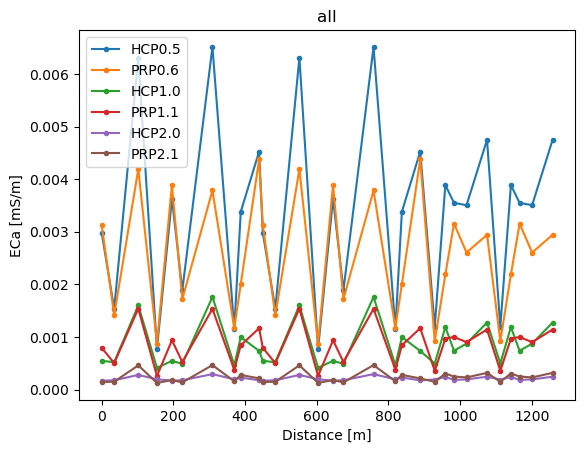

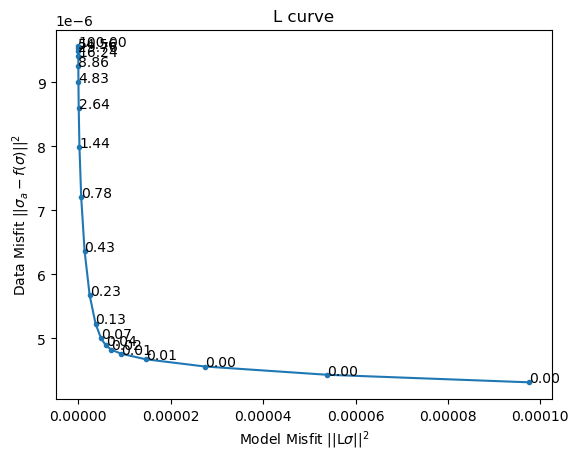

In [6]:
#depths_in = [0.1, 0.5, 0.8, 1.5]
depths_in = [0.4, 0.8]

# Set pdf name for exporting plot
pdf_name = 'Modelled_EC_profiles.pdf'

# ******************************************************************** #
# Create an inversion problem object to solve with EMagPy

sampling_path = samples
sample_transect = Problem()
sample_transect.createSurvey(sampling_path, freq=9e3,hx=0.165,unit='ECa')
sample_transect.setInit(depths0=depths_in)
sample_transect.show()
sample_transect.lcurve()

# Run the inversion
sample_transect.invert( alpha=0.03, njobs=-1) # FSIQ, alpha  check forwardModel='FSeq',
print('   Finished inversion')

# ----------------------------------------------------------------------
# Plotting and exporting the EC profiles figure as a pdf
# ----------------------------------------------------------------------

# Putting the results in a dataframe, and concatenate with analytical data.
depth_values = sample_transect.depths[0][0]
layer_cols = ['EC_{:.2f}'.format(d) for d in depth_values] + ['EC_end']
data = np.c_[sample_transect.surveys[0].df[['x', 'y']].values, 
             sample_transect.models[0]]

ds_inv = pd.DataFrame(data, columns=['x', 'y'] + layer_cols)
selected_columns_ds = pd.concat([ds_c.iloc[:, 3:11], ds_c.iloc[:, 17:]], axis=1)

ds_all = pd.concat([ds_inv, selected_columns_ds], axis=1)
#ds_all = ds_all.dropna()

unique_sample_ids = ds_all['name'].unique()

# Calculate number of rows and columns for the subplot
subplot_rows = 3
subplot_cols = 5

# Get axis limits
global_x_min = ds_all[layer_cols].min().min()
global_x_max = ds_all[layer_cols].max().max()

csv_filename = 'inverted_samples_PH.csv'
ds_all.to_csv(csv_filename)

## 

In [7]:
# Calculate the Bulk EC DC inverted at suitable depth based on invertion layers.
bulk_ec_dc_010 = []
for i in range(len(ds_all.bulk_ec_hp.values)):
    res = minimize(objective_func_ec_dc, 0.05, args=(9e3, ds_all['EC_0.40'][i]), bounds=[(0, 1)])
    bulk_ec_dc_010.append(np.nan if np.isnan(res.fun) else round(res.x[0], 5) )

ds_all['bulk_ec_dc_010'] = bulk_ec_dc_010
ds_all_10cm = ds_all.loc[ds_all['depth']==10].reset_index(drop=True)

bulk_ec_dc_050 = []
for i in range(len(ds_all.bulk_ec_hp.values)):
    res = minimize(objective_func_ec_dc, 0.05, args=(9e3, ds_all['EC_0.80'][i]), bounds=[(0, 1)])
    bulk_ec_dc_050.append(np.nan if np.isnan(res.fun) else round(res.x[0], 5) )

ds_all['bulk_ec_dc_050'] = bulk_ec_dc_050
ds_all_50cm = ds_all.loc[ds_all['depth']==50].reset_index(drop=True)

ds_all['bulk_ec_dc_inv'] = [ds_all.bulk_ec_dc_010[i] if ds_all.depth[i] == 10 else ds_all.bulk_ec_dc_050[i] for i in range(len(ds_all.vwc))]
ds_all['bulk_ec_dc_inv_t'] = SheetsHendrickxEC(ds_all.bulk_ec_dc_inv, ds_all.temp)

In [8]:
ds_f = ds_all[['x', 'y', 'z', 't', 'HCP0.5_DC_t', 'PRP0.6_DC_t', 'HCP1.0_DC_t',
       'PRP1.1_DC_t', 'HCP2.0_DC_t', 'PRP2.1_DC_t', 'ph-eau', 'CEC', 'clay', 'silt', 'sand',
        'bd', 'vwc', 'temp', 'rperm', 'iperm', 'bulk_ec_hp', 'water_ec_hp_t', 'bulk_ec_dc_inv_t']]

#sns.pairplot(ds_f)

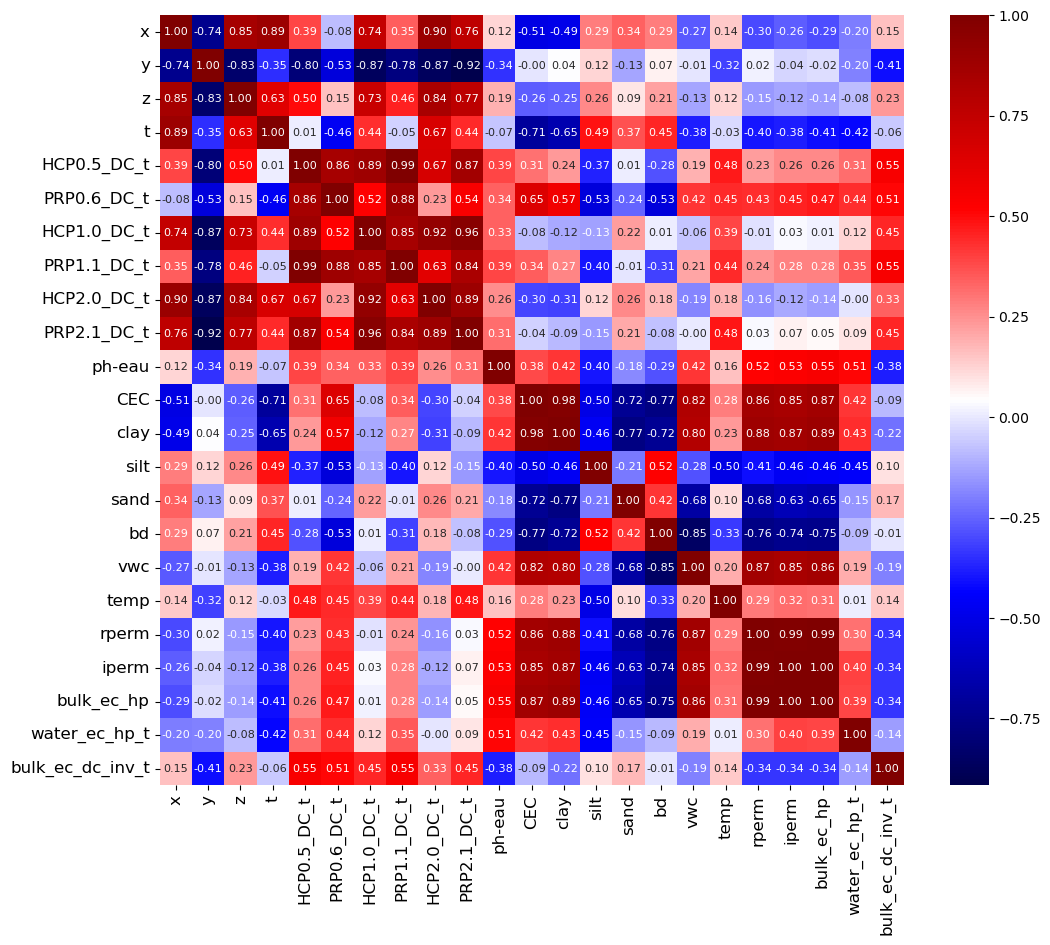

In [9]:
# Setting the figure size
plt.figure(figsize=(12, 10))

# Plotting correlation heatmap with annotations
dataplot = sns.heatmap(ds_f.corr(), cmap="seismic", annot=True, fmt=".2f", annot_kws={"size": 8})

dataplot.tick_params(axis='both', which='major', labelsize=12)

# Rotating y-axis labels for better visualization
dataplot.set_yticklabels(dataplot.get_yticklabels(), rotation=0)

# Setting the label size for x and y axes
dataplot.set_xlabel(dataplot.get_xlabel(), fontsize=14)
dataplot.set_ylabel(dataplot.get_ylabel(), fontsize=14)

plt.show()

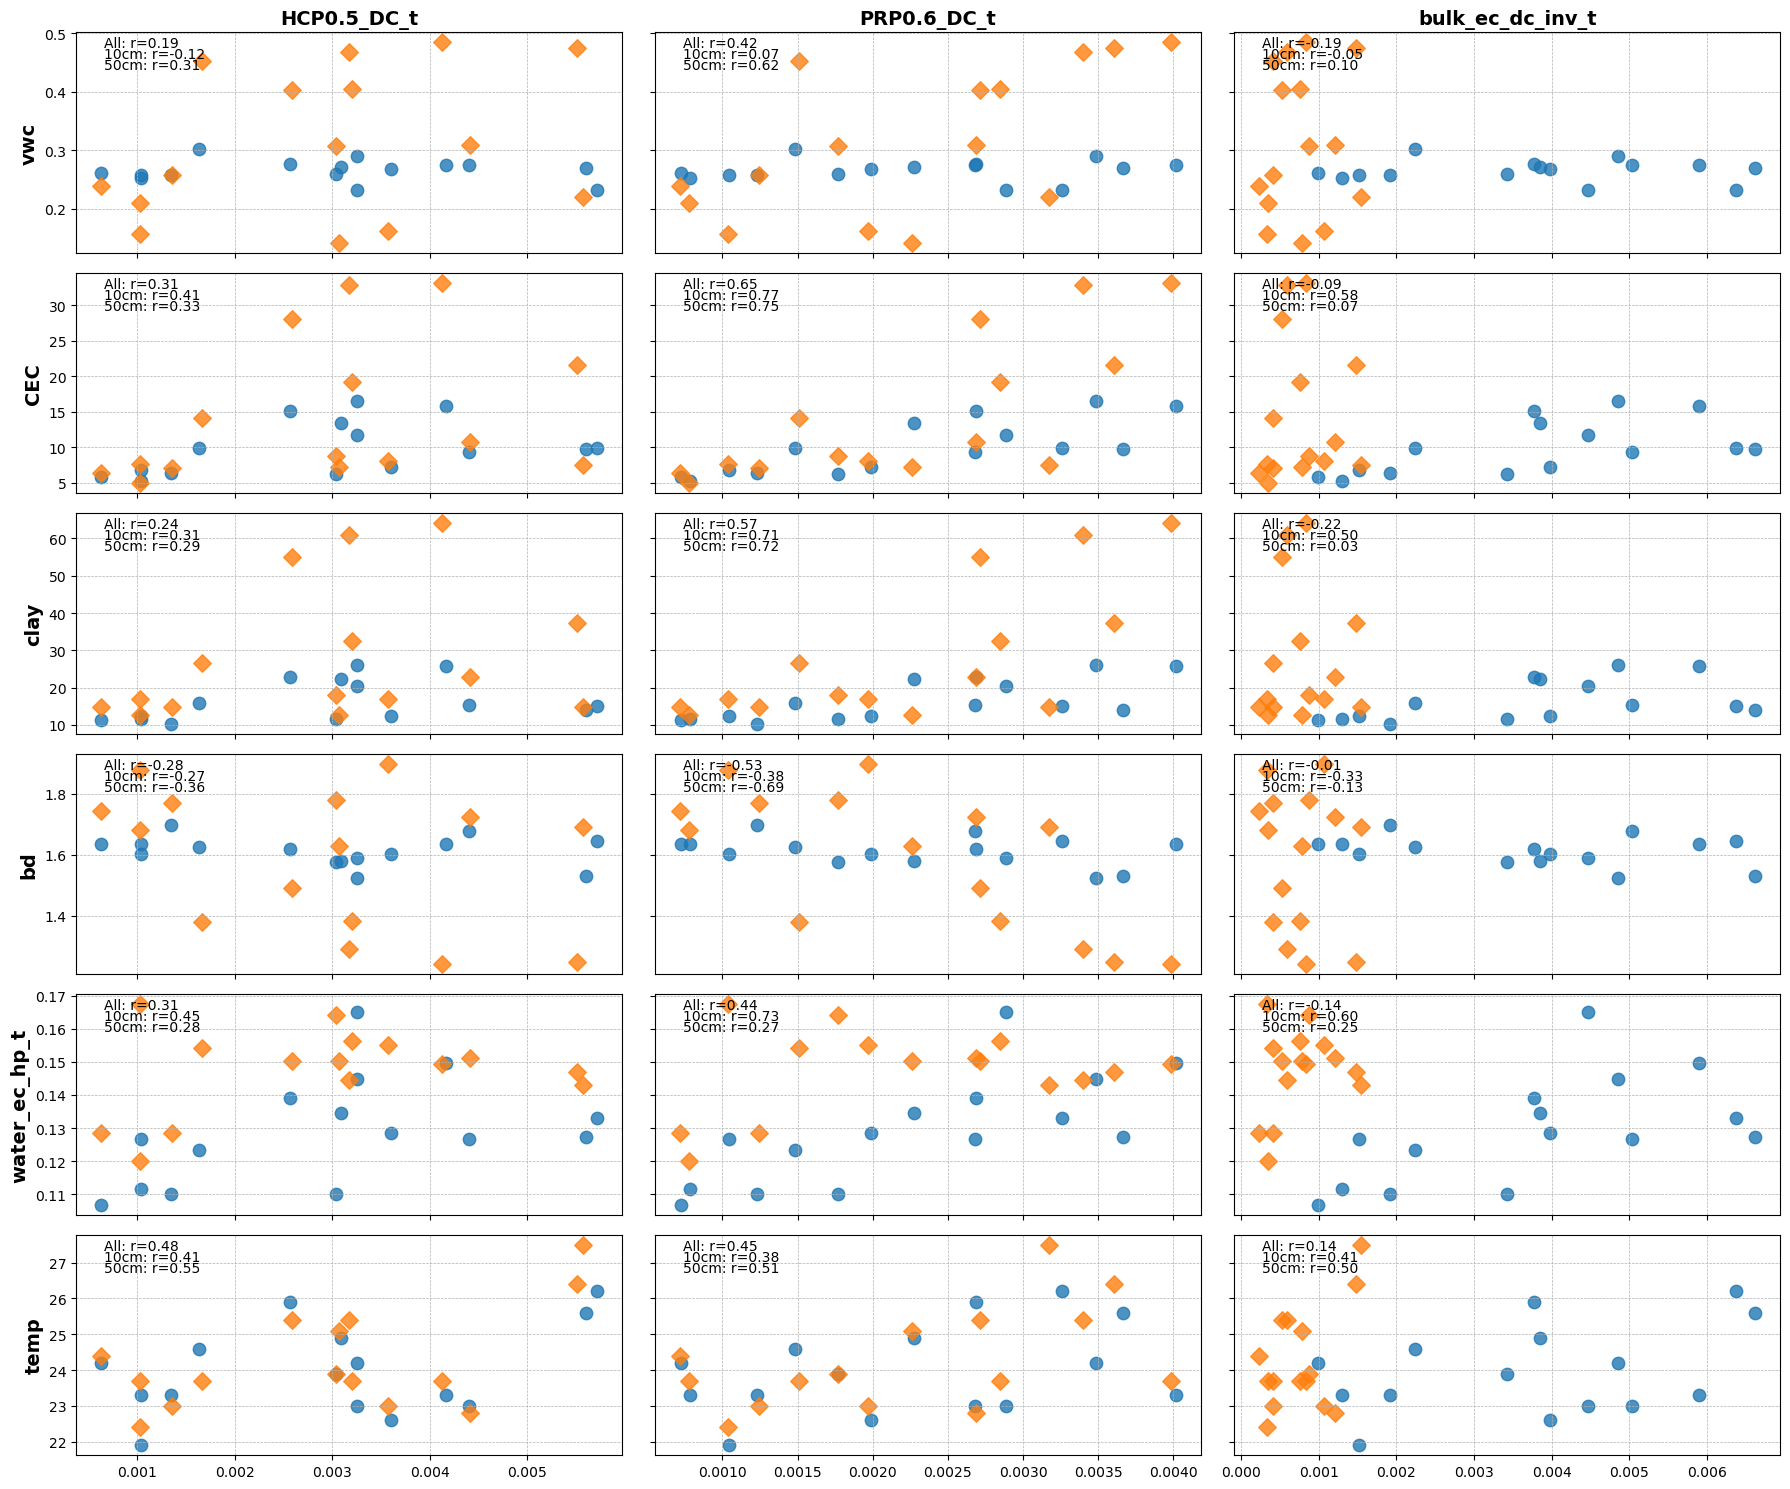

In [10]:
fig, axes = plt.subplots(6, 3, figsize=(18, 15))
ss = 80

targets = ['vwc', 'CEC', 'clay', 'bd', 'water_ec_hp_t', 'temp']
preds = ['HCP0.5_DC_t', 'PRP0.6_DC_t', 'bulk_ec_dc_inv_t']

def corr_plot(df, preds, targets):

    for target_index, target in enumerate(targets):
        for pred_index, pred in enumerate(preds):

            ax = axes[target_index, pred_index]
            
            # Add grid to the subplot
            ax.grid(True, which='both', linestyle='--', linewidth=0.5)
            
            # General correlation coefficient
            general_corr = np.corrcoef(df[pred].dropna(), df[target].dropna())[0, 1]
            ax.text(0.05, 0.95, f'All: r={general_corr:.2f}', transform=ax.transAxes, va="center")

            for layer_cm in [10, 50]:
                x_data = df[df['depth'] == layer_cm][pred]
                y_data = df[df['depth'] == layer_cm][target]
                
                # Calculate correlation coefficient for the specific depth
                corr = np.corrcoef(x_data.dropna(), y_data.dropna())[0, 1]

                if layer_cm == 10:
                    ax.scatter(x_data, y_data, s=ss, alpha=0.8, marker='o')
                    ax.text(0.05, 0.9, f'10cm: r={corr:.2f}', transform=ax.transAxes, va="center")
                if layer_cm == 50:
                    ax.scatter(x_data, y_data, s=ss, alpha=0.8, marker='D')
                    ax.text(0.05, 0.85, f'50cm: r={corr:.2f}', transform=ax.transAxes, va="center")

            # Set titles for columns
            if target_index == 0:
                ax.set_title(pred, fontweight='bold', fontsize=14)
            if target_index != len(targets) - 1:  # not the bottom row
                ax.set_xticklabels([])

            # Set row labels for the leftmost plots
            if pred_index == 0:
                ax.set_ylabel(target, fontweight='bold', fontsize=14)
            if pred_index != 0:  # not the first column
                ax.set_yticklabels([])

corr_plot(ds_all, preds, targets)
plt.tight_layout()

## Deterministic modelling

In [11]:
clay_50cm = np.mean(ds_all.clay[ds_all['depth']==50])
clay_10cm = np.mean(ds_all.clay[ds_all['depth']==10])
bd_50cm = np.mean(ds_all.bd[ds_all['depth']==50])
bd_10cm = np.mean(ds_all.bd[ds_all['depth']==10])
water_ec_hp_50cm_t = np.mean(ds_all.water_ec_hp_t[ds_all['depth']==50])
water_ec_hp_10cm_t = np.mean(ds_all.water_ec_hp_t[ds_all['depth']==10])

# Defining minimization function to obtain water using Fu
def objective_func_wat(x, clay, bulk_density, particle_density, water_ec, solid_ec, dry_ec, sat_ec, EC):
    return (Fu(x, clay, bulk_density, particle_density, water_ec, solid_ec, dry_ec, sat_ec) - EC)**2

def calculate_water(ds, col, round_n=3):
    wat = []
    for dc in ds[col]:
        index = ds.index[ds[col] == dc][0]
        if ds.depth[index] == 50:
            res = minimize(objective_func_wat, 0.15, args=(clay_50cm, bd_50cm, 2.65, water_ec_hp_50cm_t, 
                                                       0, np.nan, np.nan, dc), bounds=[(0, .65)])
        else:
            res = minimize(objective_func_wat, 0.15, args=(clay_10cm, bd_10cm, 2.65, water_ec_hp_10cm_t, 
                                                       0, np.nan, np.nan, dc), bounds=[(0, .65)])            
        wat.append(np.nan if np.isnan(res.fun) else round(res.x[0], round_n))

    r2_val = round(r2_score(ds.vwc.values, wat), round_n)
    rmse_val = round(RMSE(ds.vwc.values, wat), round_n)
    return wat, r2_val, rmse_val

HCP0.5_DC_t 0     0.002561
1     0.001346
2     0.005597
3     0.000630
4     0.003252
5     0.001633
6     0.005715
7     0.001035
8     0.003037
9     0.004163
10    0.002587
11    0.001355
12    0.005507
13    0.000627
14    0.003172
15    0.001664
16    0.005569
17    0.001024
18    0.003037
19    0.004128
20    0.001027
21    0.003575
22    0.003204
23    0.003072
24    0.004417
25    0.001036
26    0.003605
27    0.003252
28    0.003085
29    0.004398
Name: HCP0.5_DC_t, dtype: float64
wat [0.041, 0.023, 0.082, 0.011, 0.051, 0.027, 0.084, 0.018, 0.048, 0.064, 0.023, 0.012, 0.047, 0.006, 0.028, 0.015, 0.048, 0.009, 0.048, 0.036, 0.009, 0.031, 0.028, 0.027, 0.038, 0.018, 0.056, 0.051, 0.048, 0.067]
for predicting water deterministically, the best predictor is:HCP0.5_DC_t


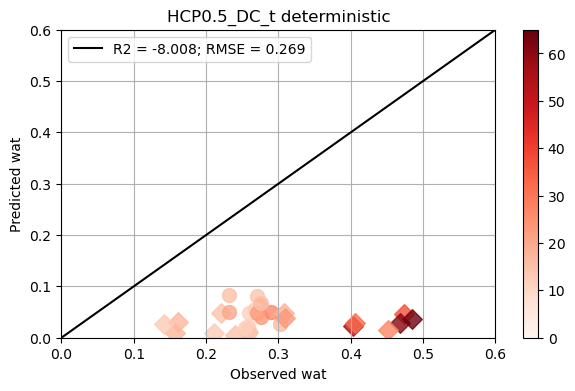

HCP1.0_DC_t 0     0.000422
1     0.000414
2     0.001343
3     0.000315
4     0.000437
5     0.000383
6     0.001463
7     0.000384
8     0.000839
9     0.000611
10    0.000426
11    0.000417
12    0.001321
13    0.000314
14    0.000426
15    0.000390
16    0.001425
17    0.000380
18    0.000839
19    0.000606
20    0.000390
21    0.001032
22    0.000606
23    0.000708
24    0.001120
25    0.000394
26    0.001041
27    0.000615
28    0.000711
29    0.001115
Name: HCP1.0_DC_t, dtype: float64
wat [0.008, 0.008, 0.023, 0.006, 0.008, 0.007, 0.024, 0.007, 0.015, 0.011, 0.004, 0.004, 0.012, 0.003, 0.004, 0.004, 0.013, 0.004, 0.015, 0.006, 0.004, 0.009, 0.006, 0.007, 0.01, 0.008, 0.018, 0.011, 0.013, 0.019]
for predicting water deterministically, the best predictor is:HCP0.5_DC_t


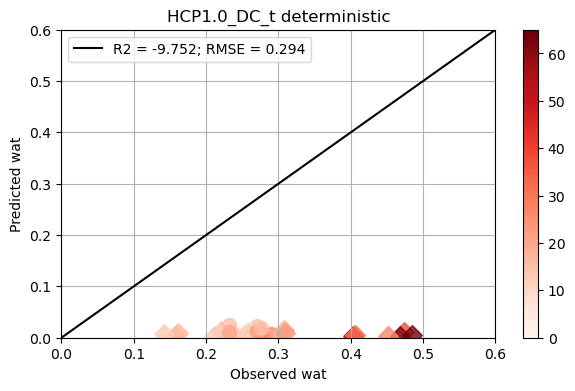

HCP2.0_DC_t 0     0.000098
1     0.000104
2     0.000158
3     0.000112
4     0.000102
5     0.000101
6     0.000156
7     0.000117
8     0.000133
9     0.000104
10    0.000099
11    0.000104
12    0.000155
13    0.000111
14    0.000099
15    0.000103
16    0.000152
17    0.000116
18    0.000133
19    0.000103
20    0.000113
21    0.000146
22    0.000113
23    0.000110
24    0.000147
25    0.000114
26    0.000147
27    0.000115
28    0.000110
29    0.000146
Name: HCP2.0_DC_t, dtype: float64
wat [0.003, 0.003, 0.004, 0.003, 0.003, 0.003, 0.004, 0.003, 0.003, 0.003, 0.001, 0.001, 0.002, 0.001, 0.001, 0.001, 0.002, 0.001, 0.003, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.003, 0.004, 0.003, 0.003, 0.001]
for predicting water deterministically, the best predictor is:HCP0.5_DC_t


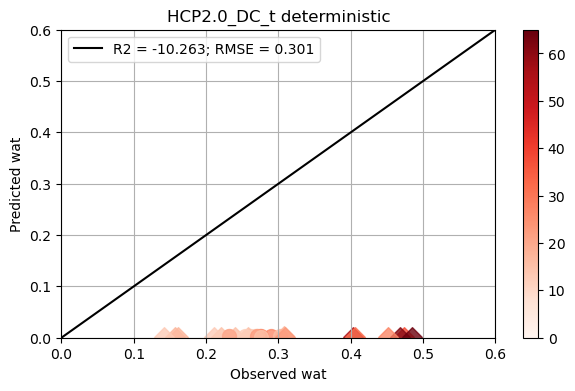

PRP0.6_DC_t 0     0.002688
1     0.001232
2     0.003663
3     0.000721
4     0.003485
5     0.001481
6     0.003257
7     0.001046
8     0.001769
9     0.004018
10    0.002716
11    0.001240
12    0.003604
13    0.000718
14    0.003400
15    0.001510
16    0.003174
17    0.001035
18    0.001769
19    0.003984
20    0.000780
21    0.001970
22    0.002844
23    0.002264
24    0.002690
25    0.000787
26    0.001987
27    0.002887
28    0.002273
29    0.002678
Name: PRP0.6_DC_t, dtype: float64
wat [0.043, 0.021, 0.056, 0.013, 0.054, 0.025, 0.051, 0.018, 0.029, 0.062, 0.024, 0.011, 0.032, 0.007, 0.03, 0.014, 0.028, 0.009, 0.029, 0.035, 0.007, 0.018, 0.025, 0.02, 0.024, 0.014, 0.032, 0.045, 0.037, 0.042]
for predicting water deterministically, the best predictor is:HCP0.5_DC_t


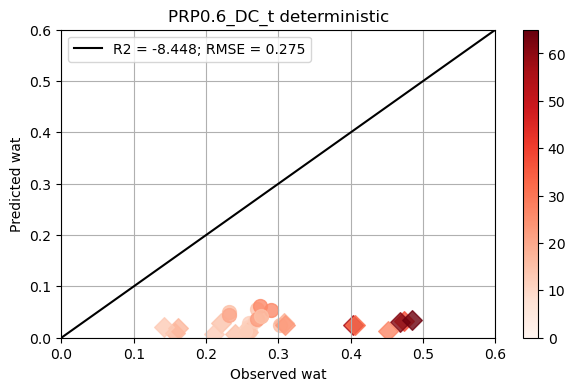

PRP1.1_DC_t 0     0.000628
1     0.000404
2     0.001283
3     0.000152
4     0.000782
5     0.000413
6     0.001268
7     0.000309
8     0.000695
9     0.001015
10    0.000634
11    0.000406
12    0.001263
13    0.000152
14    0.000763
15    0.000421
16    0.001235
17    0.000306
18    0.000695
19    0.001006
20    0.000277
21    0.000834
22    0.000842
23    0.000738
24    0.000994
25    0.000280
26    0.000841
27    0.000855
28    0.000741
29    0.000990
Name: PRP1.1_DC_t, dtype: float64
wat [0.011, 0.008, 0.022, 0.004, 0.014, 0.008, 0.021, 0.006, 0.012, 0.017, 0.006, 0.004, 0.011, 0.002, 0.007, 0.004, 0.011, 0.003, 0.012, 0.009, 0.003, 0.008, 0.008, 0.007, 0.009, 0.006, 0.015, 0.015, 0.013, 0.017]
for predicting water deterministically, the best predictor is:HCP0.5_DC_t


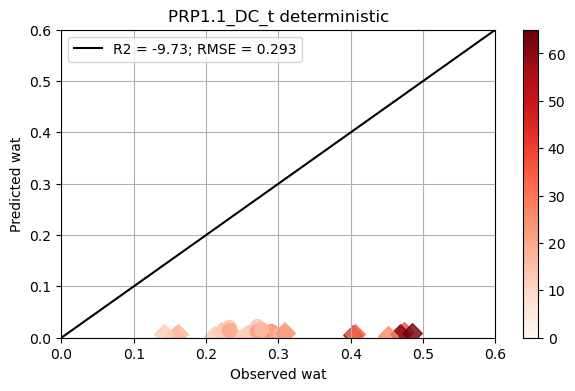

PRP2.1_DC_t 0     0.000088
1     0.000093
2     0.000346
3     0.000081
4     0.000112
5     0.000081
6     0.000351
7     0.000096
8     0.000164
9     0.000124
10    0.000089
11    0.000094
12    0.000340
13    0.000081
14    0.000109
15    0.000082
16    0.000342
17    0.000095
18    0.000164
19    0.000123
20    0.000092
21    0.000177
22    0.000144
23    0.000130
24    0.000241
25    0.000093
26    0.000179
27    0.000146
28    0.000130
29    0.000240
Name: PRP2.1_DC_t, dtype: float64
wat [0.003, 0.003, 0.007, 0.003, 0.003, 0.003, 0.007, 0.003, 0.004, 0.003, 0.001, 0.001, 0.003, 0.001, 0.001, 0.001, 0.003, 0.001, 0.004, 0.001, 0.001, 0.002, 0.001, 0.001, 0.002, 0.003, 0.004, 0.004, 0.003, 0.005]
for predicting water deterministically, the best predictor is:HCP0.5_DC_t


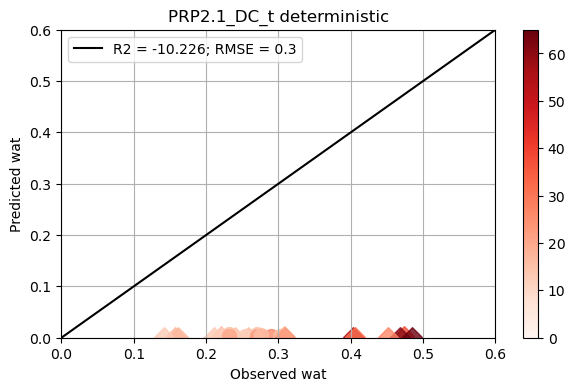

bulk_ec_dc_inv_t 0     0.003778
1     0.001916
2     0.006624
3     0.000986
4     0.004857
5     0.002237
6     0.006378
7     0.001515
8     0.003426
9     0.005903
10    0.000525
11    0.000406
12    0.001476
13    0.000233
14    0.000595
15    0.000411
16    0.001549
17    0.000338
18    0.000879
19    0.000832
20    0.000349
21    0.001063
22    0.000760
23    0.000788
24    0.001204
25    0.001305
26    0.003984
27    0.004471
28    0.003846
29    0.005034
Name: bulk_ec_dc_inv_t, dtype: float64
wat [0.058, 0.031, 0.095, 0.017, 0.073, 0.036, 0.092, 0.025, 0.053, 0.086, 0.005, 0.004, 0.013, 0.002, 0.006, 0.004, 0.014, 0.003, 0.008, 0.008, 0.003, 0.01, 0.007, 0.007, 0.011, 0.022, 0.062, 0.068, 0.059, 0.075]
for predicting water deterministically, the best predictor is:HCP0.5_DC_t


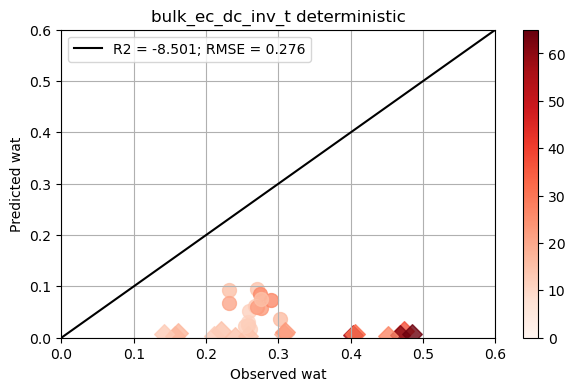

HCP0.5_DC 0     0.00261
1     0.00130
2     0.00567
3     0.00062
4     0.00320
5     0.00162
6     0.00586
7     0.00097
8     0.00297
9     0.00402
10    0.00261
11    0.00130
12    0.00567
13    0.00062
14    0.00320
15    0.00162
16    0.00586
17    0.00097
18    0.00297
19    0.00402
20    0.00100
21    0.00343
22    0.00312
23    0.00308
24    0.00422
25    0.00100
26    0.00343
27    0.00312
28    0.00308
29    0.00422
Name: HCP0.5_DC, dtype: float64
wat [0.041, 0.022, 0.083, 0.011, 0.05, 0.027, 0.085, 0.017, 0.047, 0.062, 0.041, 0.022, 0.083, 0.011, 0.05, 0.027, 0.085, 0.017, 0.047, 0.062, 0.009, 0.03, 0.028, 0.027, 0.037, 0.009, 0.03, 0.028, 0.027, 0.037]
for predicting water deterministically, the best predictor is:HCP0.5_DC


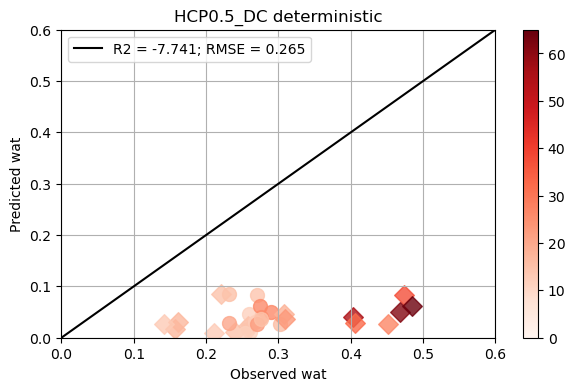

HCP1.0_DC 0     0.00043
1     0.00040
2     0.00136
3     0.00031
4     0.00043
5     0.00038
6     0.00150
7     0.00036
8     0.00082
9     0.00059
10    0.00043
11    0.00040
12    0.00136
13    0.00031
14    0.00043
15    0.00038
16    0.00150
17    0.00036
18    0.00082
19    0.00059
20    0.00038
21    0.00099
22    0.00059
23    0.00071
24    0.00107
25    0.00038
26    0.00099
27    0.00059
28    0.00071
29    0.00107
Name: HCP1.0_DC, dtype: float64
wat [0.008, 0.008, 0.023, 0.006, 0.008, 0.007, 0.025, 0.007, 0.014, 0.011, 0.008, 0.008, 0.023, 0.006, 0.008, 0.007, 0.025, 0.007, 0.014, 0.011, 0.007, 0.009, 0.011, 0.007, 0.01, 0.007, 0.009, 0.011, 0.007, 0.01]
for predicting water deterministically, the best predictor is:HCP0.5_DC


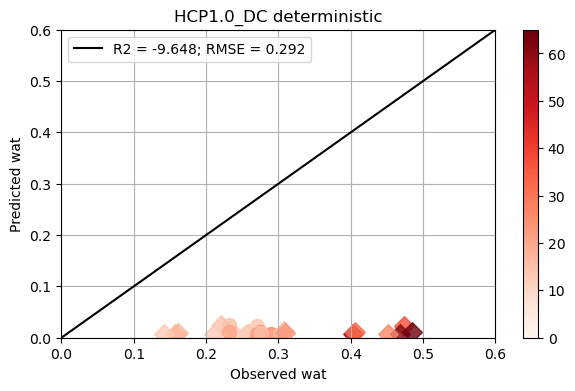

HCP2.0_DC 0     0.00010
1     0.00010
2     0.00016
3     0.00011
4     0.00010
5     0.00010
6     0.00016
7     0.00011
8     0.00013
9     0.00010
10    0.00010
11    0.00010
12    0.00016
13    0.00011
14    0.00010
15    0.00010
16    0.00016
17    0.00011
18    0.00013
19    0.00010
20    0.00011
21    0.00014
22    0.00011
23    0.00011
24    0.00014
25    0.00011
26    0.00014
27    0.00011
28    0.00011
29    0.00014
Name: HCP2.0_DC, dtype: float64
wat [0.003, 0.003, 0.004, 0.003, 0.003, 0.003, 0.004, 0.003, 0.003, 0.003, 0.003, 0.003, 0.004, 0.003, 0.003, 0.003, 0.004, 0.003, 0.003, 0.003, 0.003, 0.001, 0.003, 0.003, 0.001, 0.003, 0.001, 0.003, 0.003, 0.001]
for predicting water deterministically, the best predictor is:HCP0.5_DC


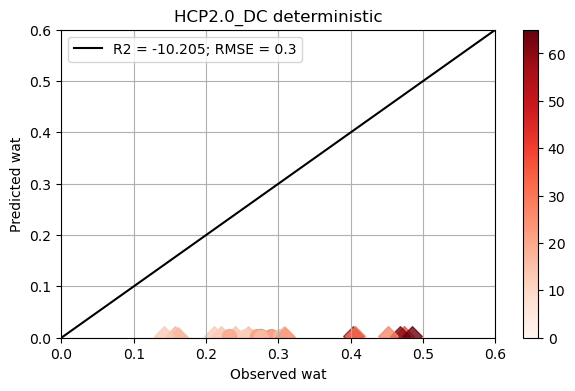

PRP0.6_DC 0     0.00274
1     0.00119
2     0.00371
3     0.00071
4     0.00343
5     0.00147
6     0.00334
7     0.00098
8     0.00173
9     0.00388
10    0.00274
11    0.00119
12    0.00371
13    0.00071
14    0.00343
15    0.00147
16    0.00334
17    0.00098
18    0.00173
19    0.00388
20    0.00076
21    0.00189
22    0.00277
23    0.00227
24    0.00257
25    0.00076
26    0.00189
27    0.00277
28    0.00227
29    0.00257
Name: PRP0.6_DC, dtype: float64
wat [0.043, 0.02, 0.057, 0.013, 0.053, 0.025, 0.052, 0.017, 0.028, 0.06, 0.043, 0.02, 0.057, 0.013, 0.053, 0.025, 0.052, 0.017, 0.028, 0.06, 0.007, 0.017, 0.025, 0.02, 0.023, 0.007, 0.017, 0.025, 0.02, 0.023]
for predicting water deterministically, the best predictor is:HCP0.5_DC


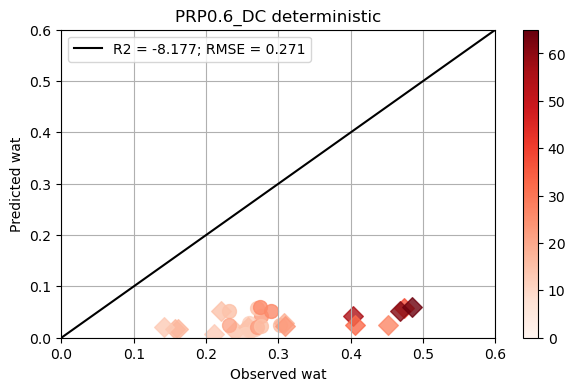

PRP1.1_DC 0     0.00064
1     0.00039
2     0.00130
3     0.00015
4     0.00077
5     0.00041
6     0.00130
7     0.00029
8     0.00068
9     0.00098
10    0.00064
11    0.00039
12    0.00130
13    0.00015
14    0.00077
15    0.00041
16    0.00130
17    0.00029
18    0.00068
19    0.00098
20    0.00027
21    0.00080
22    0.00082
23    0.00074
24    0.00095
25    0.00027
26    0.00080
27    0.00082
28    0.00074
29    0.00095
Name: PRP1.1_DC, dtype: float64
wat [0.012, 0.008, 0.022, 0.004, 0.014, 0.008, 0.022, 0.006, 0.012, 0.017, 0.012, 0.008, 0.022, 0.004, 0.014, 0.008, 0.022, 0.006, 0.012, 0.017, 0.003, 0.007, 0.008, 0.007, 0.009, 0.003, 0.007, 0.008, 0.007, 0.009]
for predicting water deterministically, the best predictor is:HCP0.5_DC


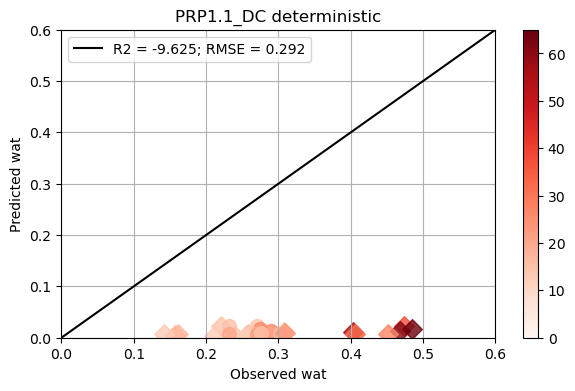

PRP2.1_DC 0     0.00009
1     0.00009
2     0.00035
3     0.00008
4     0.00011
5     0.00008
6     0.00036
7     0.00009
8     0.00016
9     0.00012
10    0.00009
11    0.00009
12    0.00035
13    0.00008
14    0.00011
15    0.00008
16    0.00036
17    0.00009
18    0.00016
19    0.00012
20    0.00009
21    0.00017
22    0.00014
23    0.00013
24    0.00023
25    0.00009
26    0.00017
27    0.00014
28    0.00013
29    0.00023
Name: PRP2.1_DC, dtype: float64
wat [0.003, 0.003, 0.007, 0.003, 0.003, 0.003, 0.007, 0.003, 0.004, 0.003, 0.003, 0.003, 0.007, 0.003, 0.003, 0.003, 0.007, 0.003, 0.004, 0.003, 0.003, 0.002, 0.001, 0.001, 0.002, 0.003, 0.002, 0.001, 0.001, 0.002]
for predicting water deterministically, the best predictor is:HCP0.5_DC


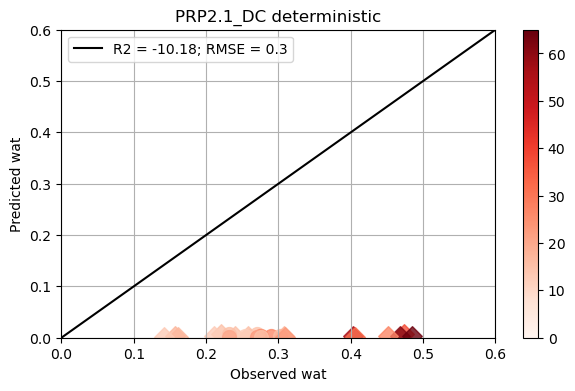

bulk_ec_dc_inv 0     0.00385
1     0.00185
2     0.00671
3     0.00097
4     0.00478
5     0.00222
6     0.00654
7     0.00142
8     0.00335
9     0.00570
10    0.00053
11    0.00039
12    0.00152
13    0.00023
14    0.00060
15    0.00040
16    0.00163
17    0.00032
18    0.00086
19    0.00081
20    0.00034
21    0.00102
22    0.00074
23    0.00079
24    0.00115
25    0.00126
26    0.00379
27    0.00429
28    0.00384
29    0.00483
Name: bulk_ec_dc_inv, dtype: float64
wat [0.06, 0.03, 0.096, 0.017, 0.072, 0.036, 0.094, 0.024, 0.052, 0.083, 0.005, 0.004, 0.014, 0.002, 0.006, 0.004, 0.015, 0.003, 0.008, 0.007, 0.003, 0.009, 0.007, 0.007, 0.01, 0.021, 0.058, 0.066, 0.059, 0.072]
for predicting water deterministically, the best predictor is:HCP0.5_DC


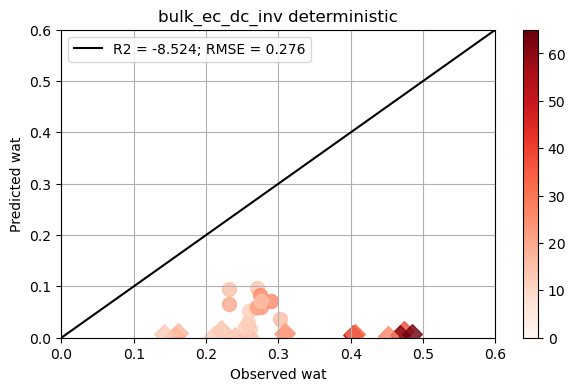

,Target,Best EC feature,R2
0,vwc,HCP0.5_DC,-7.741
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


In [12]:
feature_set = [
    'HCP0.5_DC_t',
    'HCP1.0_DC_t',
    'HCP2.0_DC_t',
    'PRP0.6_DC_t',
    'PRP1.1_DC_t',
    'PRP2.1_DC_t',
    'bulk_ec_dc_inv_t',

    'HCP0.5_DC',
    'HCP1.0_DC',
    'HCP2.0_DC',
    'PRP0.6_DC',
    'PRP1.1_DC',
    'PRP2.1_DC',
    'bulk_ec_dc_inv',
]

target = ds_all['vwc']
R2_, RMSE_, WAT_ = [], [], []

i = 0
for feature in feature_set:
    print(feature, ds_all[feature])
    title = feature+' deterministic'
    wat, r2, rmse = calculate_water(ds_all, feature)
    print('wat', wat)
    R2_.append(r2)
    RMSE_.append(rmse)
    WAT_.append(wat)

    best_index = R2_.index(np.max(R2_))

    R2_deterministic['R2'][0] = R2_[best_index]
    RMSE_deterministic['RMSE'][0] = RMSE_[best_index]
    R2_deterministic['Best EC feature'][0] = feature_set[best_index]
    RMSE_deterministic['Best EC feature'][0] = feature_set[best_index]
    R2_deterministic['Target'][0] = 'vwc'
    RMSE_deterministic['Target'][0] = 'vwc'

    print('for predicting water deterministically, the best predictor is:' +feature_set[best_index])

    plot_results(ds_all, target, wat, r2, rmse, ds_all.clay, title)

R2_deterministic

In [13]:
RMSE_deterministic

,Target,Best EC feature,RMSE
0,vwc,HCP0.5_DC,0.265
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


## Stochastic modelling (no layer distinction)

In [14]:
feature_sets = [
    ['HCP0.5'],
    ['HCP1.0'],
    ['HCP2.0'],
    ['HCP0.5', 'HCP1.0'],
    ['HCP0.5', 'HCP2.0'],
    ['HCP1.0', 'HCP2.0'],
#    ['HCP0.5', 'HCP1.0', 'HCP2.0'],
    ['PRP0.6'],
    ['PRP1.1'],
    ['PRP2.1'],
    ['PRP0.6', 'PRP1.1'],
    ['PRP0.6', 'PRP2.1'],
    ['PRP1.1', 'PRP2.1'],
#    ['PRP0.6', 'PRP1.1', 'PRP2.1'], 
    ['PRP0.6', 'HCP0.5'],
    ['bulk_ec_dc_inv'],
    ['bulk_ec_dc_inv_t']
#    ['bulk_ec_dc_inv', 'PRP0.6', 'HCP0.5']
]

In [15]:
def stochastic_poly(df, feature_columns, Y, n=4, iters=100, round_n=3):
    ypred_train_best, ypred_test_best, R2_train_t_best, R2_test_t_best, RMSE_train_t_best, RMSE_test_t_best = [], [], [], [], [], []
    X = df[feature_columns[0]].values.reshape(-1, 1)
    
    for i in range(iters):
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=i)
        LinReg = LinearRegression()
        ypred_train_, ypred_test_, R2_train_t_, R2_test_t_, RMSE_train_t_, RMSE_test_t_ = [], [], [], [], [], []

        for k in range(n):
            poly = PolynomialFeatures(degree=k)
            poly.fit(X_train)
            Xt_train = poly.transform(X_train)
            Xt_test = poly.transform(X_test)

            LinReg.fit(Xt_train, y_train)
            ypred_train = LinReg.predict(Xt_train)
            ypred_test = LinReg.predict(Xt_test)

            R2_train_t = r2_score(y_train, ypred_train)
            R2_test_t = r2_score(y_test, ypred_test)
            RMSE_train_t = RMSE(y_train, ypred_train)
            RMSE_test_t = RMSE(y_test, ypred_test)

            ypred_train_.append(ypred_train)
            ypred_test_.append(ypred_test)
            R2_train_t_.append(R2_train_t)
            R2_test_t_.append(R2_test_t)
            RMSE_train_t_.append(RMSE_train_t)
            RMSE_test_t_.append(RMSE_test_t)

        ypred_train_best.append(ypred_train_)
        ypred_test_best.append(ypred_test_)
        R2_train_t_best.append(R2_train_t_)
        R2_test_t_best.append(R2_test_t_)
        RMSE_train_t_best.append(RMSE_train_t_)
        RMSE_test_t_best.append(RMSE_test_t_)

    RMSE_test_n1 = [inner_list[0] for inner_list in RMSE_test_t_best]
    RMSE_test_n2 = [inner_list[1] for inner_list in RMSE_test_t_best]
    RMSE_test_n3 = [inner_list[2] for inner_list in RMSE_test_t_best]
    RMSE_test_n4 = [inner_list[3] for inner_list in RMSE_test_t_best]
    
    RMSE_sums = [np.mean(RMSE_test_n1), np.mean(RMSE_test_n2), np.mean(RMSE_test_n3), np.mean(RMSE_test_n4)]
    best_n = RMSE_sums.index(np.min(RMSE_sums))
    return best_n, round(np.mean([inner_list[best_n] for inner_list in R2_test_t_best]), round_n), round(np.mean([inner_list[best_n] for inner_list in R2_train_t_best]), round_n), round(np.mean([inner_list[best_n] for inner_list in RMSE_test_t_best]), round_n), round(np.mean([inner_list[best_n] for inner_list in RMSE_train_t_best]), round_n)         


def implementation(df, features, target, n):           
    # Create a polynomial regression model
    if isinstance(features, (list, tuple)):
        X = df[list(features)]
    else:
        X = df[features][:, np.newaxis]
    
    # Create a polynomial regression model
    model = make_pipeline(PolynomialFeatures(degree=n), LinearRegression())
    model.fit(X, df[target])
    
    # Predict y values
    predictions = model.predict(X)
    
    # Compute R^2 and RMSE
    r2 = r2_score(df[target], predictions)
    rmse = RMSE(df[target], predictions)
    
    # For plotting purposes, we'll use the first feature in the list (or the only feature)
    primary_feature = features[0] if isinstance(features, (list, tuple)) else features
    x_fit = np.linspace(min(df[primary_feature]), max(df[primary_feature]), 500)
    
    # If multiple features, we need to ensure the shape of x_fit matches
    if isinstance(features, (list, tuple)) and len(features) > 1:
        X_fit = pd.DataFrame({feature: x_fit if feature == primary_feature else df[feature].values 
                              for feature in features})
    else:
        X_fit = x_fit[:, np.newaxis]
    
    y_fit = model.predict(X_fit)
    
    # Plotting
    plt.scatter(df[primary_feature], df[target], label='Data Points')
    
    # Plot points where df['depth'] == 50 with 'D' marker
    depth_mask = df['depth'] == 50
    plt.scatter(df[primary_feature][depth_mask], df[target][depth_mask], marker='D', label='Depth=50 Points')
    
    plt.plot(x_fit, y_fit, color='black', label=f'Polynomial (Degree {n}) Fit')
    plt.title(f'Polynomial Fit of Degree {n}\n$R^2$: {r2:.2f}, RMSE: {rmse:.2f}')
    plt.xlabel(primary_feature)
    plt.ylabel(target)
    plt.legend()
    plt.show()
    
    return model

i 0
for predicting stochastically vwc the best predictor is:PRP0.6


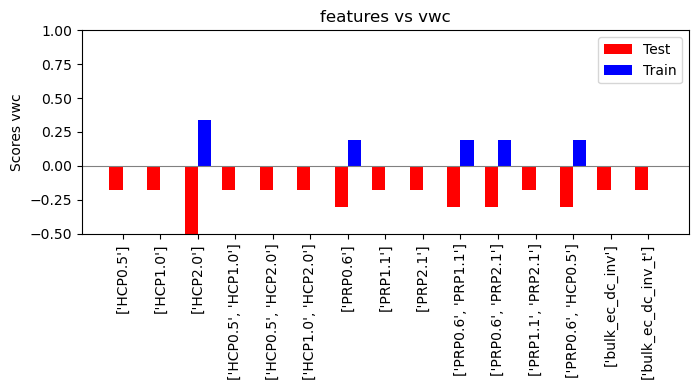

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


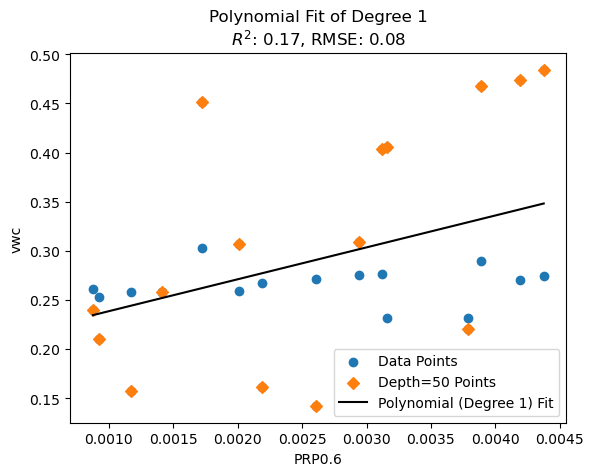

i 1
for predicting stochastically CEC the best predictor is:PRP0.6


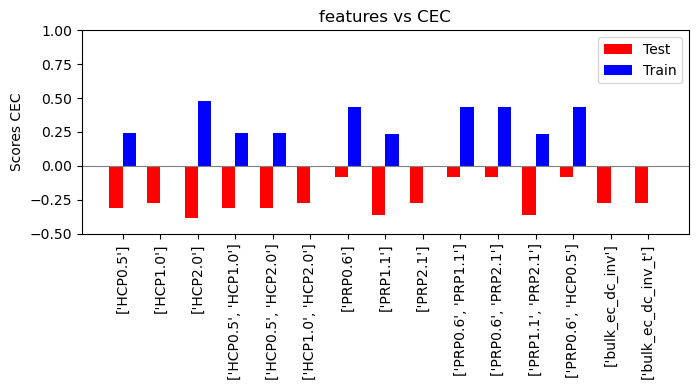

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


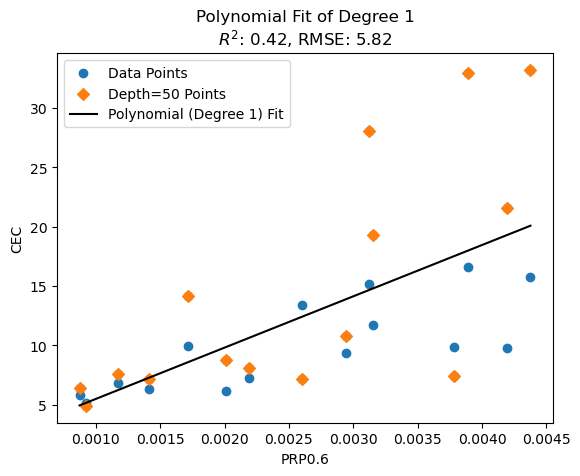

i 2
for predicting stochastically clay the best predictor is:PRP0.6


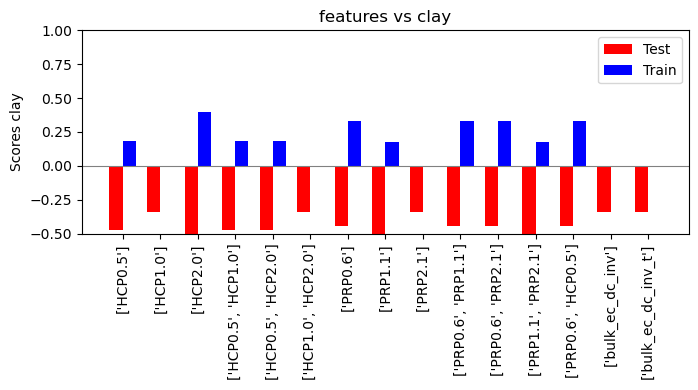

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


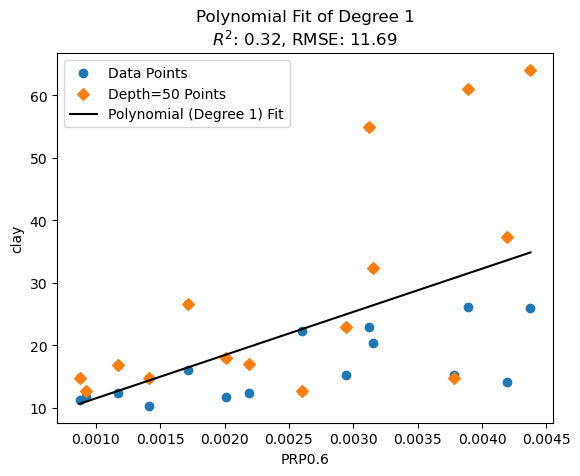

i 3
for predicting stochastically bd the best predictor is:PRP0.6


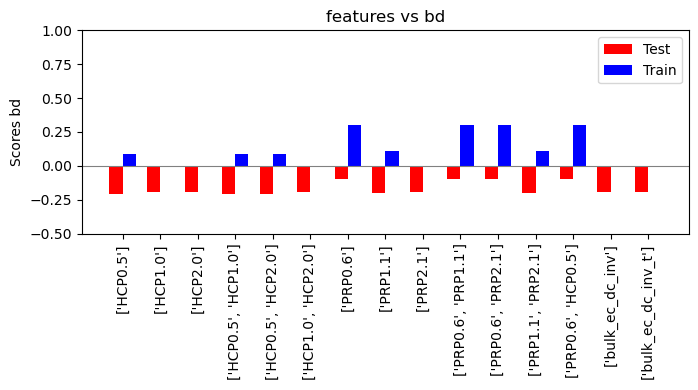

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


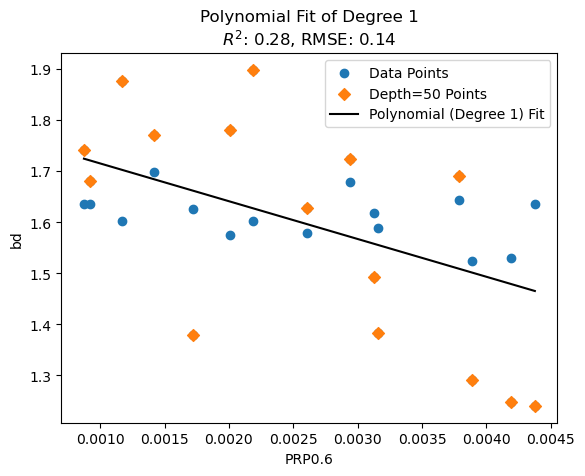

i 4
for predicting stochastically water_ec_hp_t the best predictor is:HCP0.5


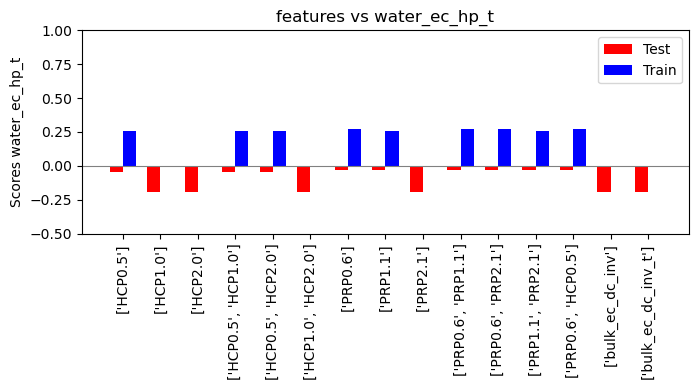

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


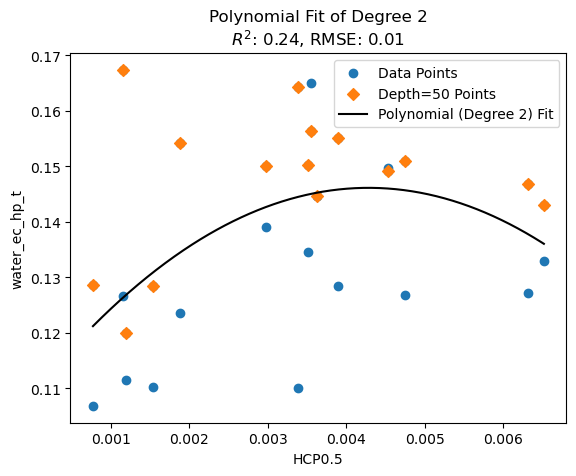

,Target,Best EC feature,R2,Best EC feature 10cm,R2 10cm,Best EC feature 50cm,R2 50cm,Best EC feature combined,R2 combined,R2 combined2
0,vwc,"(PRP0.6, 1)",-0.307,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CEC,"(PRP0.6, 1)",-0.084,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,clay,"(PRP0.6, 1)",-0.445,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bd,"(PRP0.6, 1)",-0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,water_ec_hp_t,"(HCP0.5, 2)",-0.045,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
target_set = [
    'vwc',
    'CEC',
    'clay',
    'bd',
    'water_ec_hp_t'
]

i = 0
for t in target_set:
    print('i', i)
    R2_test, R2_train, RMSE_test, n_ = [], [], [], []
    target = ds_all[t].values
    
    for feature_set in feature_sets:        
        best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol = stochastic_poly(ds_all, feature_set, target)
        #print('best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set:', best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set)
        R2_test.append(R2_test_pol)
        R2_train.append(R2_train_pol)
        RMSE_test.append(RMSE_test_pol)
        n_.append(best_n)

    best_index = RMSE_test.index(np.min(RMSE_test))
    n = n_[best_index]
    
    R2_stochastic['Best EC feature'][i] = (feature_sets[best_index][0], n)
    R2_stochastic['Target'][i] = t
    R2_stochastic['R2'][i] = R2_test[best_index]
    RMSE_stochastic['Best EC feature'][i] = (feature_sets[best_index][0], n)
    RMSE_stochastic['Target'][i] = t
    RMSE_stochastic['RMSE'][i] = RMSE_test[best_index]

    print('for predicting stochastically '+ t+' the best predictor is:' +feature_sets[best_index][0])
    bars_plot(feature_sets, R2_test, R2_train, t)
    implementation(ds_all, feature_sets[best_index], t, n)

    i+=1
R2_stochastic

In [17]:
RMSE_stochastic

,Target,Best EC feature,RMSE,Best EC feature 10cm,RMSE 10cm,Best EC feature 50cm,RMSE 50cm,Best EC feature combined,RMSE combined,RMSE combined2
0,vwc,"(PRP0.6, 1)",0.088,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CEC,"(PRP0.6, 1)",6.077,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,clay,"(PRP0.6, 1)",12.271,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bd,"(PRP0.6, 1)",0.148,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,water_ec_hp_t,"(HCP0.5, 2)",0.016,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Layered stochastic modelling

In [18]:
def stochastic_poly_(df, feature_columns, target, n=4, iters=100, round_n=3):
    R2_train_t_10_, R2_test_t_10_, RMSE_train_t_10_, RMSE_test_t_10_, ypred_test_10_ = [], [], [], [], []
    R2_train_t_50_, R2_test_t_50_, RMSE_train_t_50_, RMSE_test_t_50_, ypred_test_50_ = [], [], [], [], []
    R2_train_t_, R2_test_t_, RMSE_train_t_, RMSE_test_t_ = [], [], [], []
    y_test_ = []

    for i in range(iters):

        X_layer_10 = df[df['depth'] == 10][feature_columns[0]].values.reshape(-1, 1)
        Y_layer_10 = df[df['depth'] == 10][target].values

        X_train10, X_test10, y_train10, y_test10 = train_test_split(X_layer_10, Y_layer_10, test_size=0.3, random_state=i)
        R2_train_t_10, R2_test_t_10, RMSE_train_t_10, RMSE_test_t_10, ypred_test_10 = [], [], [], [], []
######
######
        X_layer_50 = df[df['depth'] == 50][feature_columns[0]].values.reshape(-1, 1)
        Y_layer_50 = df[df['depth'] == 50][target].values

        X_train50, X_test50, y_train50, y_test50 = train_test_split(X_layer_50, Y_layer_50, test_size=0.3, random_state=i)
        R2_train_t_50, R2_test_t_50, RMSE_train_t_50, RMSE_test_t_50, ypred_test_50 = [], [], [], [], []
        
        y_train = np.concatenate((y_train10, y_train50))
        y_test = np.concatenate((y_test10, y_test50))
        y_test_.append(y_test)
        R2_train_t_comb, R2_test_t_comb, RMSE_train_t_comb, RMSE_test_t_comb = [], [], [], []
        
        for k in range(n):
            LinReg10 = LinearRegression()
            poly10 = PolynomialFeatures(degree=k)
            poly10.fit(X_train10)
            Xt_train10 = poly10.transform(X_train10)
            Xt_test10 = poly10.transform(X_test10)

            LinReg10.fit(Xt_train10, y_train10)
            ypred_train10 = LinReg10.predict(Xt_train10)
            ypred_test10 = LinReg10.predict(Xt_test10)
            ypred_test_10.append(ypred_test10)

            R2_train_t10 = r2_score(y_train10, ypred_train10)
            R2_test_t10 = r2_score(y_test10, ypred_test10)
            RMSE_train_t10 = RMSE(y_train10, ypred_train10)
            RMSE_test_t10 = RMSE(y_test10, ypred_test10)

            R2_train_t_10.append(R2_train_t10)
            R2_test_t_10.append(R2_test_t10)
            RMSE_train_t_10.append(RMSE_train_t10)
            RMSE_test_t_10.append(RMSE_test_t10)

            LinReg50 = LinearRegression()
            poly50 = PolynomialFeatures(degree=k)
            poly50.fit(X_train50)
            Xt_train50 = poly50.transform(X_train50)
            Xt_test50 = poly50.transform(X_test50)

            LinReg50.fit(Xt_train50, y_train50)
            ypred_train50 = LinReg50.predict(Xt_train50)
            ypred_test50 = LinReg50.predict(Xt_test50)
            ypred_test_50.append(ypred_test50)

            ypred_train = np.concatenate((ypred_train10, ypred_train50))
            ypred_test = np.concatenate((ypred_test10, ypred_test50))

            R2_train_t50 = r2_score(y_train50, ypred_train50)
            R2_test_t50 = r2_score(y_test50, ypred_test50)
            RMSE_train_t50 = RMSE(y_train50, ypred_train50)
            RMSE_test_t50 = RMSE(y_test50, ypred_test50)

            R2_train_t_50.append(R2_train_t50)
            R2_test_t_50.append(R2_test_t50)
            RMSE_train_t_50.append(RMSE_train_t50)
            RMSE_test_t_50.append(RMSE_test_t50)

            R2_train_t = r2_score(y_train, ypred_train)
            R2_test_t = r2_score(y_test, ypred_test)
            RMSE_train_t = RMSE(y_train, ypred_train)
            RMSE_test_t = RMSE(y_test, ypred_test)

            R2_train_t_.append(R2_train_t)
            R2_test_t_.append(R2_test_t)
            RMSE_train_t_.append(RMSE_train_t)
            RMSE_test_t_.append(RMSE_test_t)

        R2_train_t_10_.append(R2_train_t_10)
        R2_test_t_10_.append(R2_test_t_10)
        RMSE_train_t_10_.append(RMSE_train_t_10)
        RMSE_test_t_10_.append(RMSE_test_t_10)
        ypred_test_10_.append(ypred_test_10)

        R2_train_t_50_.append(R2_train_t_50)
        R2_test_t_50_.append(R2_test_t_50)
        RMSE_train_t_50_.append(RMSE_train_t_50)
        RMSE_test_t_50_.append(RMSE_test_t_50)
        ypred_test_50_.append(ypred_test_50)

        R2_train_t_comb.append(R2_train_t_)
        R2_test_t_comb.append(R2_test_t_)
        RMSE_train_t_comb.append(RMSE_train_t_)
        RMSE_test_t_comb.append(RMSE_test_t_)

    RMSE_test_n1_10 = [inner_list[0] for inner_list in RMSE_test_t_10_]
    RMSE_test_n2_10 = [inner_list[1] for inner_list in RMSE_test_t_10_]
    RMSE_test_n3_10 = [inner_list[2] for inner_list in RMSE_test_t_10_]
    RMSE_test_n4_10 = [inner_list[3] for inner_list in RMSE_test_t_10_]

    RMSE_test_n1_50 = [inner_list[0] for inner_list in RMSE_test_t_50_]
    RMSE_test_n2_50 = [inner_list[1] for inner_list in RMSE_test_t_50_]
    RMSE_test_n3_50 = [inner_list[2] for inner_list in RMSE_test_t_50_]
    RMSE_test_n4_50 = [inner_list[3] for inner_list in RMSE_test_t_50_]

    RMSE_test_n1 = [inner_list[0] for inner_list in RMSE_test_t_comb]
    RMSE_test_n2 = [inner_list[1] for inner_list in RMSE_test_t_comb]
    RMSE_test_n3 = [inner_list[2] for inner_list in RMSE_test_t_comb]
    RMSE_test_n4 = [inner_list[3] for inner_list in RMSE_test_t_comb]

    RMSE_mean_10 = [np.mean(RMSE_test_n1_10), np.mean(RMSE_test_n2_10), np.mean(RMSE_test_n3_10), np.mean(RMSE_test_n4_10)]
    best_n_10 = RMSE_mean_10.index(np.min(RMSE_mean_10))

    RMSE_mean_50 = [np.mean(RMSE_test_n1_50), np.mean(RMSE_test_n2_50), np.mean(RMSE_test_n3_50), np.mean(RMSE_test_n4_50)]
    best_n_50 = RMSE_mean_50.index(np.min(RMSE_mean_50))

    RMSE_mean = [np.mean(RMSE_test_n1), np.mean(RMSE_test_n2), np.mean(RMSE_test_n3), np.mean(RMSE_test_n4)]
    best_n = RMSE_mean.index(np.min(RMSE_mean))

    for j in range(iters):
        _10 = [inner_list[best_n_10] for inner_list in ypred_test_10_][j]
        _50 = [inner_list[best_n_50] for inner_list in ypred_test_50_][j]
        ypred_1050 = np.concatenate((_10, _50))

        ytest_1050 =  y_test_[j]

        R2_1050 = r2_score(ytest_1050, ypred_1050)
        RMSE_1050 = RMSE(ytest_1050, ypred_1050)

    return best_n_10, round(np.mean([inner_list[best_n_10] for inner_list in R2_test_t_10_]), round_n), round(np.mean([inner_list[best_n_10] for inner_list in R2_train_t_10_]), round_n), round(np.mean([inner_list[best_n_10] for inner_list in RMSE_test_t_10_]), round_n), round(np.mean([inner_list[best_n_10] for inner_list in RMSE_train_t_10_]), round_n), best_n_50, round(np.mean([inner_list[best_n_50] for inner_list in R2_test_t_50_]), round_n), round(np.mean([inner_list[best_n_50] for inner_list in R2_train_t_50_]), round_n), round(np.mean([inner_list[best_n_50] for inner_list in RMSE_test_t_50_]), round_n), round(np.mean([inner_list[best_n_50] for inner_list in RMSE_train_t_50_]), round_n), best_n, round(np.mean([inner_list[best_n] for inner_list in R2_test_t_comb]), round_n), round(np.mean([inner_list[best_n] for inner_list in R2_train_t_comb]), round_n), round(np.mean([inner_list[best_n] for inner_list in RMSE_test_t_comb]), round_n), round(np.mean([inner_list[best_n] for inner_list in RMSE_train_t_comb]), round_n), round(R2_1050, round_n), round(RMSE_1050, round_n)   

Predicting stochastically vwc with combined layer modelling, the best predictor is: HCP2.0 with ply grade: 1


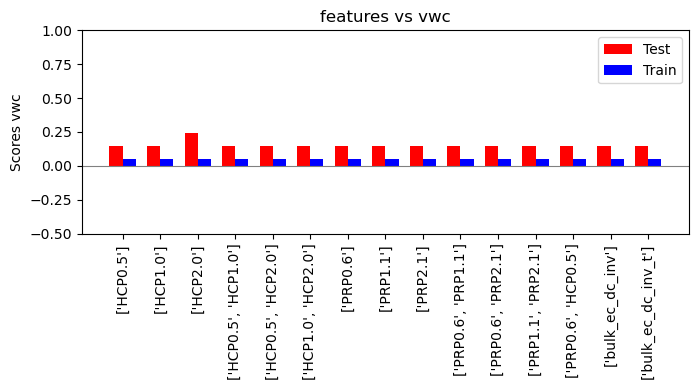

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


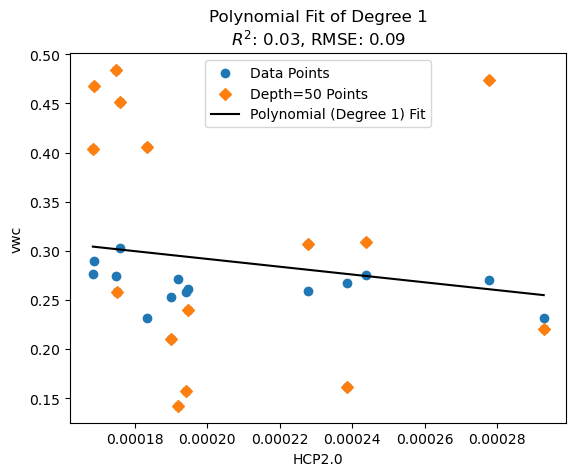

Predicting stochastically vwc for the 10 cm layer, the best predictor is: HCP0.5 with ply grade: 0


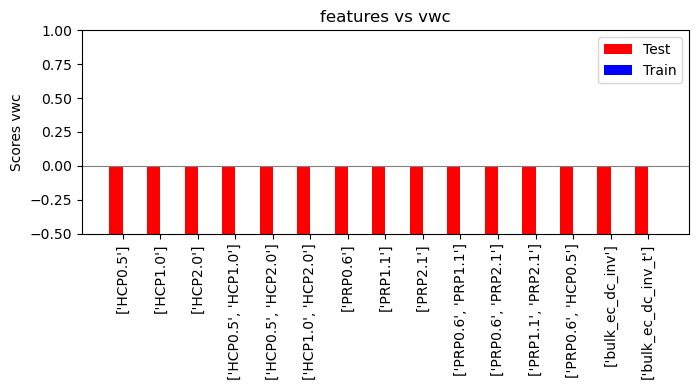

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


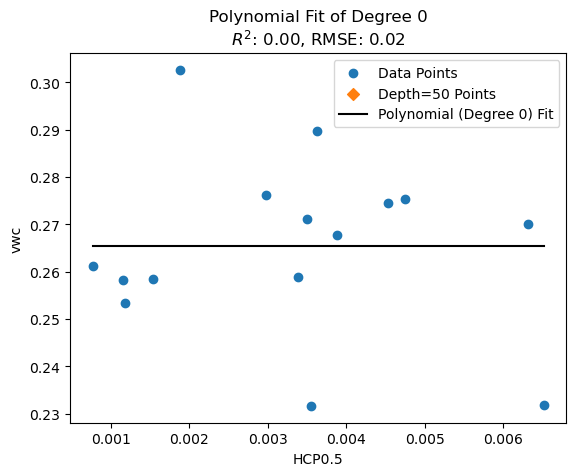

Predicting stochastically vwc for the 50 cm layer, the best predictor is: PRP0.6 with ply grade: 1


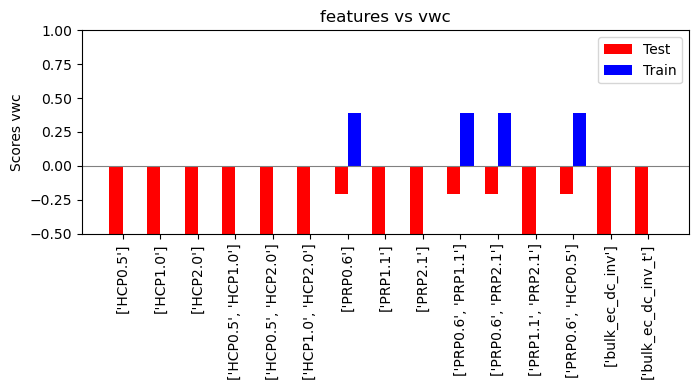

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


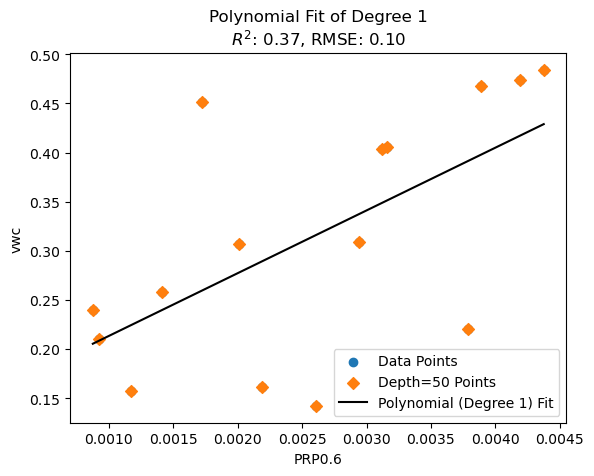

Predicting stochastically CEC with combined layer modelling, the best predictor is: PRP0.6 with ply grade: 1


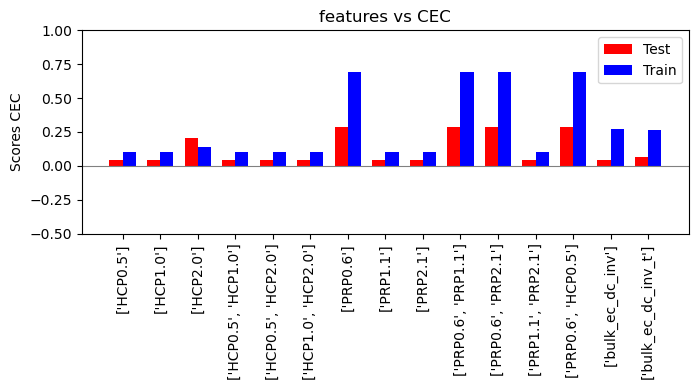

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


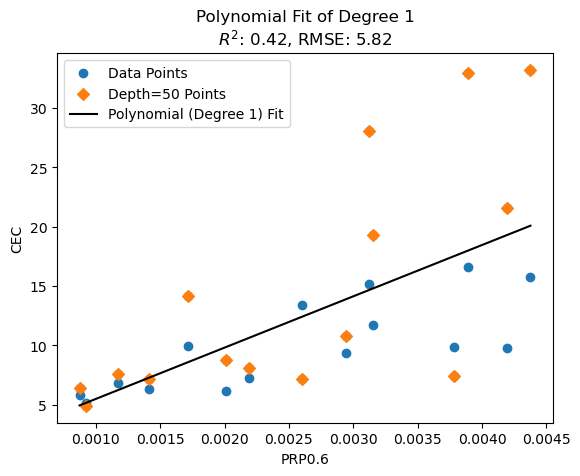

Predicting stochastically CEC for the 10 cm layer, the best predictor is: PRP0.6 with ply grade: 1


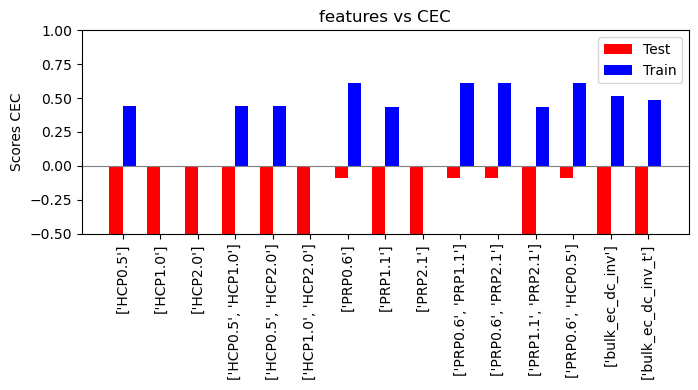

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


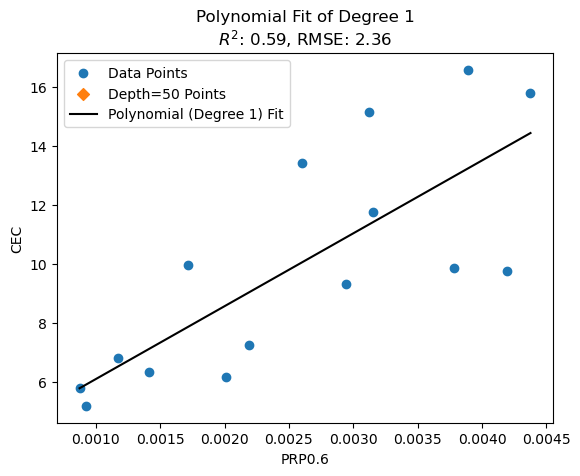

Predicting stochastically CEC for the 50 cm layer, the best predictor is: PRP0.6 with ply grade: 1


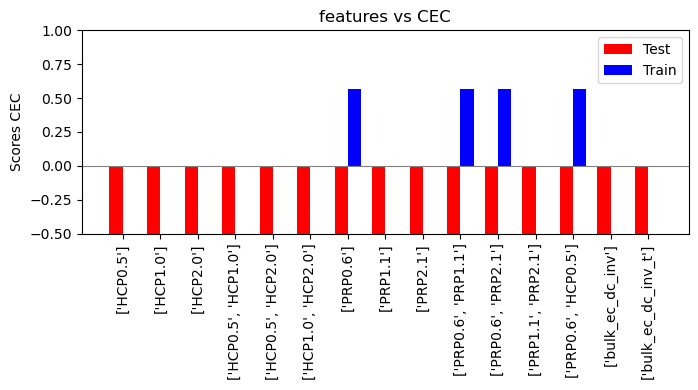

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


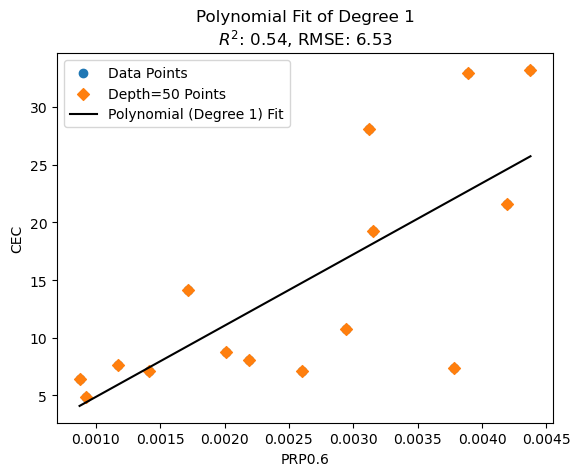

Predicting stochastically clay with combined layer modelling, the best predictor is: PRP0.6 with ply grade: 2


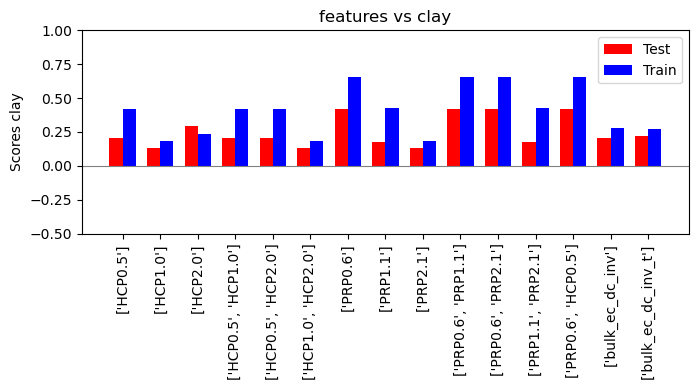

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


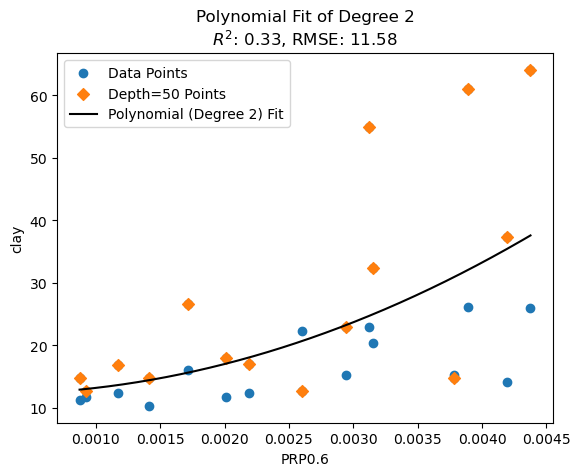

Predicting stochastically clay for the 10 cm layer, the best predictor is: PRP0.6 with ply grade: 1


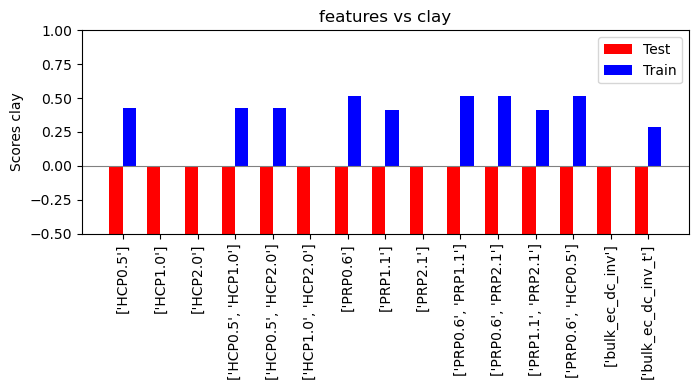

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


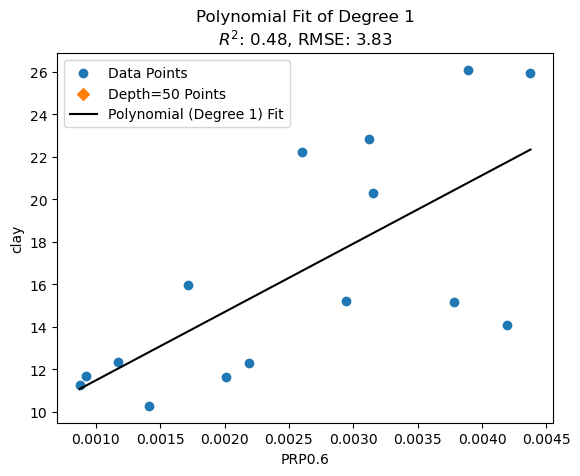

Predicting stochastically clay for the 50 cm layer, the best predictor is: PRP0.6 with ply grade: 1


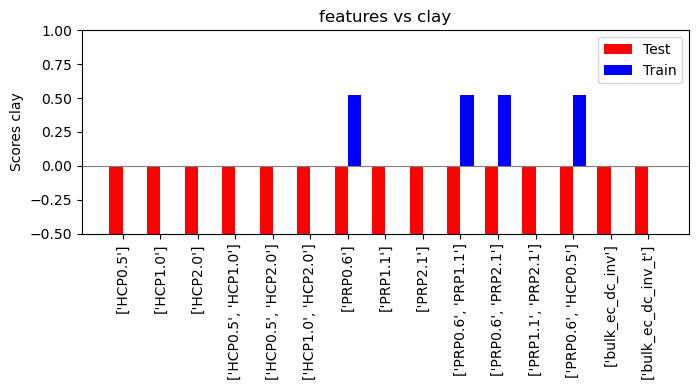

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


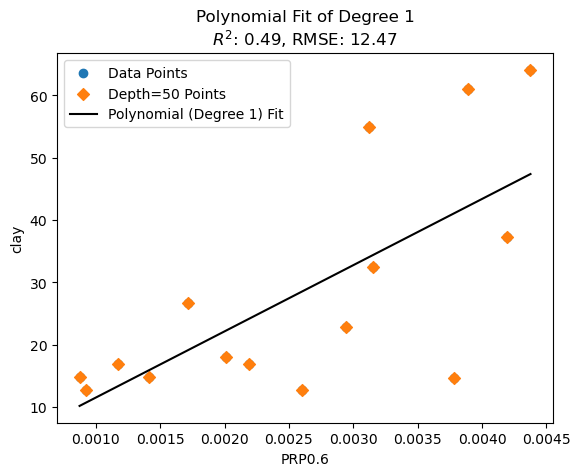

Predicting stochastically bd with combined layer modelling, the best predictor is: PRP0.6 with ply grade: 2


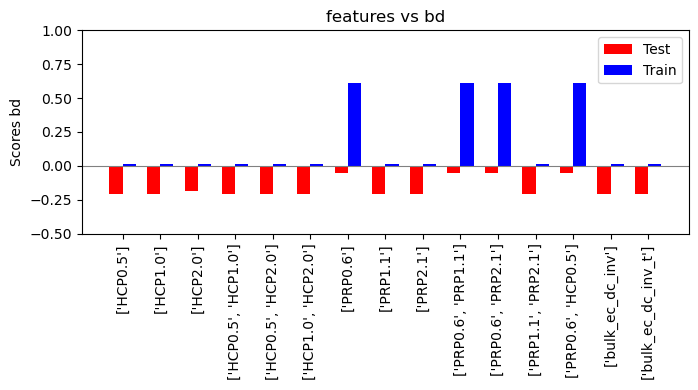

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


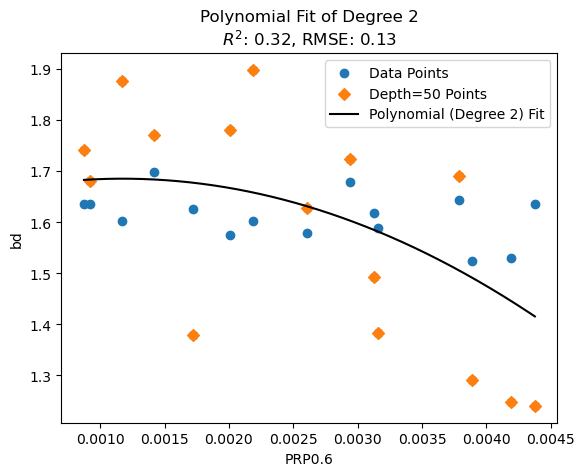

Predicting stochastically bd for the 10 cm layer, the best predictor is: HCP0.5 with ply grade: 0


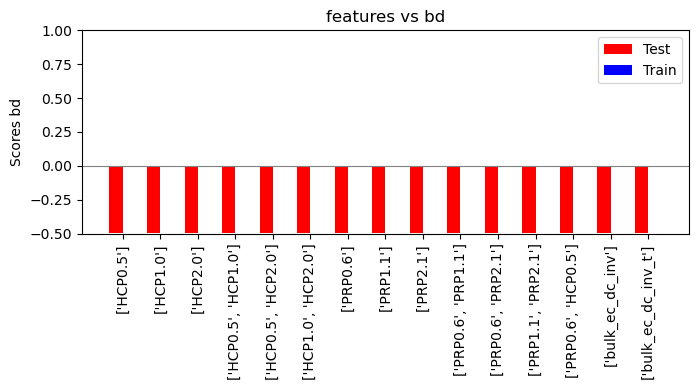

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


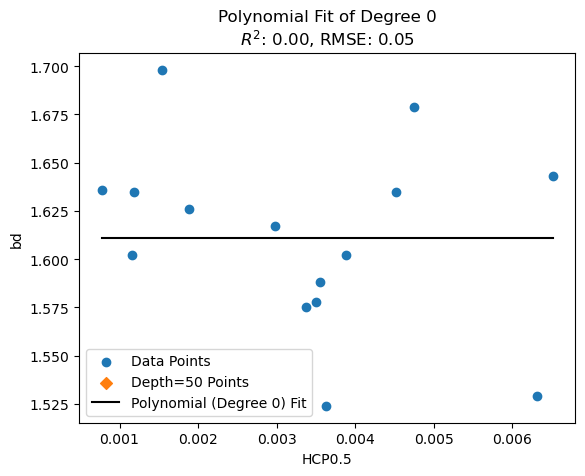

Predicting stochastically bd for the 50 cm layer, the best predictor is: PRP0.6 with ply grade: 1


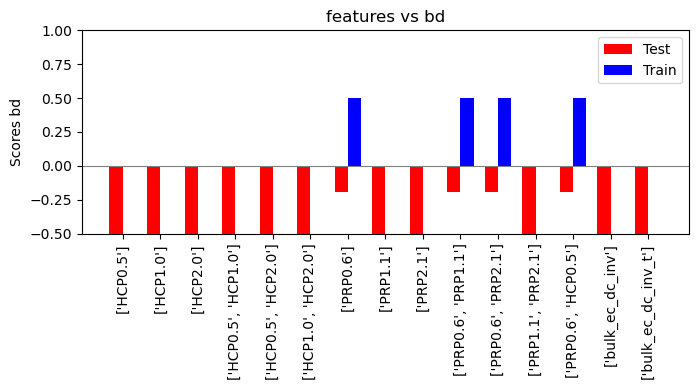

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


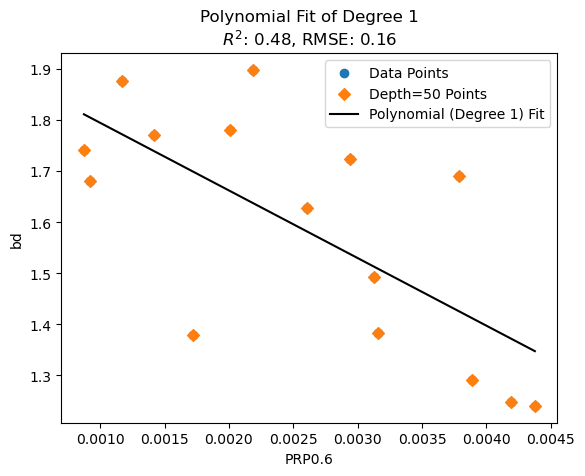

Predicting stochastically water_ec_hp_t with combined layer modelling, the best predictor is: PRP0.6 with ply grade: 1


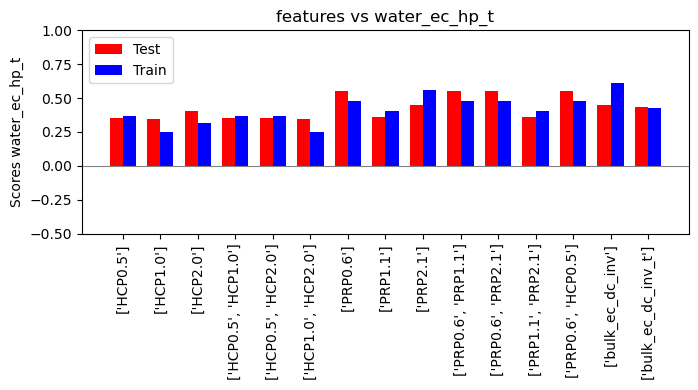

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


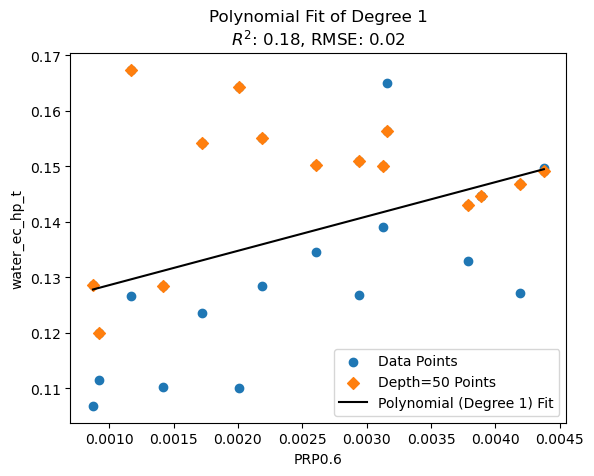

Predicting stochastically water_ec_hp_t for the 10 cm layer, the best predictor is: PRP0.6 with ply grade: 1


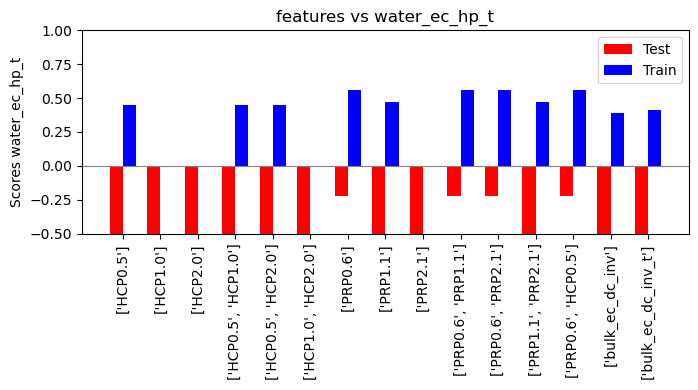

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


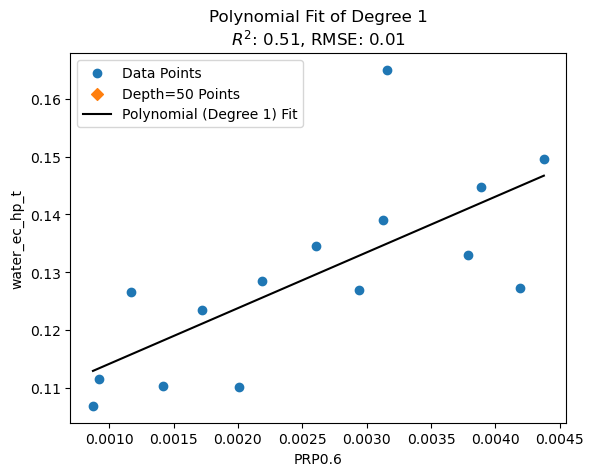

Predicting stochastically water_ec_hp_t for the 50 cm layer, the best predictor is: PRP0.6 with ply grade: 3


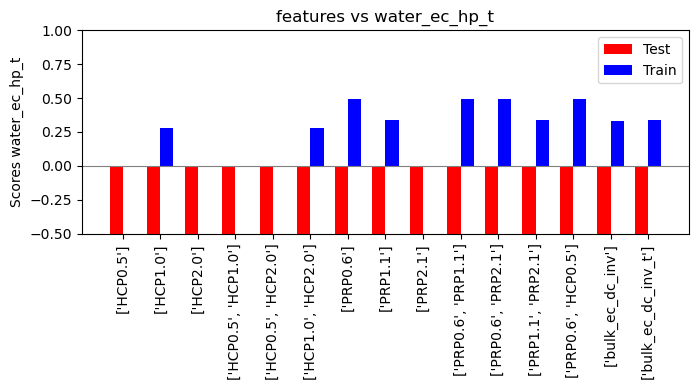

c:\Users\mendo\anaconda3_2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


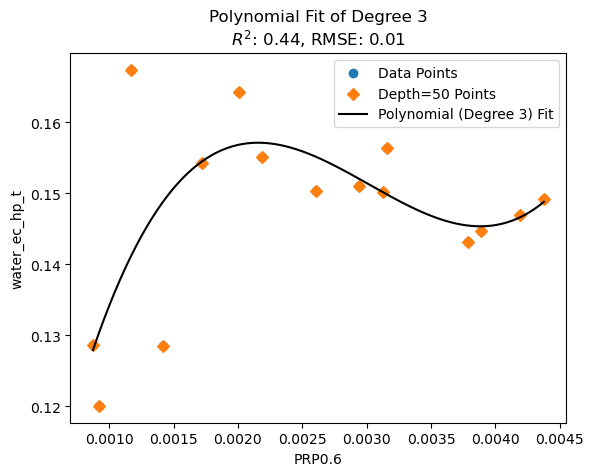

,Target,Best EC feature,R2,Best EC feature 10cm,R2 10cm,Best EC feature 50cm,R2 50cm,Best EC feature combined,R2 combined,R2 combined2
0,vwc,"(PRP0.6, 1)",-0.307,"([HCP0.5], 0)",-0.525,"([PRP0.6], 1)",-0.209,"([HCP2.0], 1)",0.243,-0.832
1,CEC,"(PRP0.6, 1)",-0.084,"([PRP0.6], 1)",-0.088,"([PRP0.6], 1)",-1.614,"([PRP0.6], 1)",0.285,-0.145
2,clay,"(PRP0.6, 1)",-0.445,"([PRP0.6], 1)",-1.028,"([PRP0.6], 1)",-1.842,"([PRP0.6], 2)",0.418,-0.056
3,bd,"(PRP0.6, 1)",-0.1,"([HCP0.5], 0)",-0.493,"([PRP0.6], 1)",-0.194,"([PRP0.6], 2)",-0.056,-0.966
4,water_ec_hp_t,"(HCP0.5, 2)",-0.045,"([PRP0.6], 1)",-0.223,"([PRP0.6], 3)",-1.724,"([PRP0.6], 1)",0.552,0.668


In [19]:
target_set = [
    'vwc',
    'CEC',
    'clay',
    'bd',
    'water_ec_hp_t'
]

i=0
for t in target_set:
    R2_test, R2_train, n_comb, RMSE_test = [], [], [], []
    R2_test_10, R2_train_10, n_10, RMSE_test_10 = [], [], [], []
    R2_test_50, R2_train_50, n_50, RMSE_test_50 = [], [], [], []
    R2_1050_, RMSE_1050_ = [], []

    target = ds_all[t].values

    for feature_set in feature_sets:        
        best_n_10, R2_test_pol_10, R2_train_pol_10, RMSE_test_pol_10, RMSE_train_pol_10, best_n_50, R2_test_pol_50, R2_train_pol_50, RMSE_test_pol_50, RMSE_train_pol_50, best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, R2_1050, RMSE_1050 = stochastic_poly_(ds_all, feature_set, t)
        
        R2_test.append(R2_test_pol)
        R2_train.append(R2_train_pol)
        n_comb.append(best_n)
        RMSE_test.append(RMSE_test_pol)

        R2_test_10.append(R2_test_pol_10)
        R2_train_10.append(R2_train_pol_10)
        n_10.append(best_n_10)
        RMSE_test_10.append(RMSE_test_pol_10)

        R2_test_50.append(R2_test_pol_50)
        R2_train_50.append(R2_train_pol_50)
        n_50.append(best_n_50)
        RMSE_test_50.append(RMSE_test_pol_50)

        R2_1050_.append(R2_1050)
        RMSE_1050_.append(RMSE_1050)

    best_index = RMSE_test.index(np.min(RMSE_test))
    n_ = n_comb[best_index]
    R2_stochastic['Best EC feature combined'][i] = (feature_sets[best_index], n_)
    R2_stochastic['Target'][i] = t
    R2_stochastic['R2 combined'][i] = R2_test[best_index]
    RMSE_stochastic['Best EC feature combined'][i] = (feature_sets[best_index], n_)
    RMSE_stochastic['Target'][i] = t
    RMSE_stochastic['RMSE combined'][i] = RMSE_test[best_index]
    print('Predicting stochastically '+t+' with combined layer modelling, the best predictor is: ' +feature_sets[best_index][0]+' with ply grade: '+str(n_))
    bars_plot(feature_sets, R2_test, R2_train, t)
    implementation(ds_all, feature_sets[best_index], t, n_)

    best_index_10 = RMSE_test_10.index(np.min(RMSE_test_10))
    n_10_ = n_10[best_index_10]
    R2_stochastic['Best EC feature '+str(10)+'cm'][i] = (feature_sets[best_index_10], n_10_)
    R2_stochastic['R2 '+str(10)+'cm'][i] = R2_test_10[best_index_10]
    RMSE_stochastic['Best EC feature '+str(10)+'cm'][i] = (feature_sets[best_index_10], n_10_)
    RMSE_stochastic['RMSE '+str(10)+'cm'][i] = RMSE_test_10[best_index_10]
    print('Predicting stochastically '+t+' for the 10 cm layer, the best predictor is: ' +feature_sets[best_index_10][0]+' with ply grade: '+str(n_10_))
    bars_plot(feature_sets, R2_test_10, R2_train_10, t)
    implementation(ds_all[ds_all['depth'] == 10], feature_sets[best_index_10], t, n_10_)

    best_index_50 = RMSE_test_50.index(np.min(RMSE_test_50))
    n_50_ = n_50[best_index_50]
    R2_stochastic['Best EC feature '+str(50)+'cm'][i] = (feature_sets[best_index_50], n_50_)
    R2_stochastic['R2 '+str(50)+'cm'][i] = R2_test_50[best_index_50]
    RMSE_stochastic['Best EC feature '+str(50)+'cm'][i] = (feature_sets[best_index_50], n_50_)
    RMSE_stochastic['RMSE '+str(50)+'cm'][i] = RMSE_test_50[best_index_50]
    print('Predicting stochastically '+t+' for the 50 cm layer, the best predictor is: ' +feature_sets[best_index_50][0]+' with ply grade: '+str(n_50_))
    bars_plot(feature_sets, R2_test_50, R2_train_50, t)
    implementation(ds_all[ds_all['depth'] == 50], feature_sets[best_index_50], t, n_50_)

    best_index_1050 = R2_1050_.index(np.max(R2_1050_))
    R2_stochastic['R2 combined2'][i] = R2_1050_[best_index_1050]
    RMSE_stochastic['RMSE combined2'][i] = RMSE_1050_[best_index_1050]

    i+=1

R2_stochastic

In [20]:
RMSE_stochastic

,Target,Best EC feature,RMSE,Best EC feature 10cm,RMSE 10cm,Best EC feature 50cm,RMSE 50cm,Best EC feature combined,RMSE combined,RMSE combined2
0,vwc,"(PRP0.6, 1)",0.088,"([HCP0.5], 0)",0.02,"([PRP0.6], 1)",0.106,"([HCP2.0], 1)",0.061,0.088
1,CEC,"(PRP0.6, 1)",6.077,"([PRP0.6], 1)",2.785,"([PRP0.6], 1)",7.538,"([PRP0.6], 1)",6.528,6.919
2,clay,"(PRP0.6, 1)",12.271,"([PRP0.6], 1)",4.538,"([PRP0.6], 1)",14.373,"([PRP0.6], 2)",11.411,12.536
3,bd,"(PRP0.6, 1)",0.148,"([HCP0.5], 0)",0.048,"([PRP0.6], 1)",0.183,"([PRP0.6], 2)",0.151,0.088
4,water_ec_hp_t,"(HCP0.5, 2)",0.016,"([PRP0.6], 1)",0.013,"([PRP0.6], 3)",0.012,"([PRP0.6], 1)",0.011,0.007
